# Analysis of HCP behavioral dataset

Rekha Varrier, main analyses Nov 2020 - Jan 2021.
- Some of the results were presented in an OHBM 2021 poster

Below are the steps to analyse the behavioral data of the HCP social task

In [250]:
#Importing data and packages, creating convenient variables
#%reset
import os
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%matplotlib inline


folder = os.getcwd()
print('current dir: ',folder)
path = Path(folder)
parent_folder = path.parent
file_loc = os.path.join(parent_folder,'data')
print('data folder:',file_loc)
old_dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding.csv')
dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding_corrected.csv')

current dir:  /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/code
data folder: /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data


In [272]:
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

dat = pd.read_csv(dataFile)# , index_col = "subj_idx")
dat_old = pd.read_csv(old_dataFile) # to compare with the old version
dat["run"] = ["run2" if x.split('.')[0] in vid_names["run1"] else "run1" for x in dat["movie"]]
dat["run"] = [0 if x.split('.')[0] in vid_names["run1"] else 1 for x in dat["movie"]]

print("n=",len(np.unique(dat["subj_idx"])))
dat.head(10)

n= 1051


,subj_idx,stim,movie,rt,response,run
0,168745,Mental,Scaring.AVI,1.252,1,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1
2,168745,Random,STAR-A.AVI,1.643,0,1
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1
4,168745,Random,TENNIS-A.AVI,1.232,0,1
5,668361,Mental,COAXING-B.AVI,1.796,9,0
6,668361,Random,BILLIARD-A.AVI,1.254,0,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0
8,668361,Mental,Fishing.AVI,0.993,0,0
9,668361,Random,Random mechanical.AVI,0.816,0,0


In [273]:
# setting default fontsizes for plots
s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'

In [274]:
print('ncorrected =:', dat.groupby(['movie']).count().subj_idx, '\n\ old:', dat_old.groupby(['movie']).count().subj_idx)

ncorrected =: movie
BILLIARD-A.AVI            990
COAXING-B.AVI            1011
DRIFTING-A.AVI           1017
Fishing.AVI               983
Random mechanical.AVI    1014
SEDUCING-B.AVI           1029
STAR-A.AVI               1027
SURPRISING-B.AVI         1035
Scaring.AVI              1027
TENNIS-A.AVI             1016
Name: subj_idx, dtype: int64 
\ old: movie
BILLIARD-A.AVI           1043
COAXING-B.AVI            1045
DRIFTING-A.AVI           1036
Fishing.AVI              1018
Random mechanical.AVI     873
SEDUCING-B.AVI           1040
STAR-A.AVI               1038
SURPRISING-B.AVI         1031
Scaring.AVI              1041
TENNIS-A.AVI              984
Name: subj_idx, dtype: int64


In [275]:
#add accuracy as an additional column, remove impossible RTs

# add accuracy
acc = np.zeros((dat.shape[0],)) -1 # initialize accuracy with -1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 1)) | ((dat['stim'] == 'Random') & (dat['response'] == 0))] = 1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 0)) | ((dat['stim'] == 'Random') & (dat['response'] == 1))] = 0
acc[dat['response'] == 9] = 9
dat['accuracy'] = acc

In [276]:
# exploring what if we don't exclude any trials?
allRTs = dat['rt'].values
print(allRTs[allRTs<=.1])
fullDat =  dat.loc[dat['rt']>=0,:]
fullDat.shape,dat.shape

[0.084 0.    0.03 ]


((10149, 7), (10149, 7))

In [277]:
fullDat.loc[fullDat['rt']<.1,:]

,subj_idx,stim,movie,rt,response,run,accuracy
3755,103212,Mental,COAXING-B.AVI,0.084,1,0,1.0
7766,112314,Random,BILLIARD-A.AVI,0.000,0,0,1.0
8018,904044,Mental,COAXING-B.AVI,0.030,1,0,1.0


In [278]:
# remove imppossible RTs
rtmin = 0.1 # threshold for impossibly short RTs
print('nrows before=',dat.shape[0])
dat= dat.loc[dat['rt']>=rtmin,:]
print('nrows after=',dat.shape[0])
#dat.head()

fullDat.shape,dat.shape


nrows before= 10149
nrows after= 10146


((10149, 7), (10146, 7))

In [258]:
# exclude bad subjects (with <10 yes/no/unsure responses)

thresh = 10

trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)
print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)

trial_counts_fullDat = fullDat.groupby("subj_idx").count()["rt"]
bad_subs_fullDat = trial_counts_fullDat[(trial_counts_fullDat < thresh)].index
fullDat  = fullDat.reset_index() # add index as an additional column "index"
fullDat = fullDat.set_index('subj_idx') # make subj_idx the index
fullDat.drop(bad_subs_fullDat, inplace=True) # remove bad subjects
fullDat = fullDat.reset_index() #bring back subj_idx as a column
fullDat = fullDat.set_index('index') # make the column "index" as the index (as in the beginning)
print("Full data, Nr. of subjects left",len(fullDat.groupby("subj_idx")))
print("Full data, Nr. of rows:",fullDat.shape)

Nr. of subjects left 823
Nr. of rows: (8230, 7)
Full data, Nr. of subjects left 826
Full data, Nr. of rows: (8260, 7)


In [259]:
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

In [260]:
dat.to_csv(os.path.join(file_loc,'data_for_paper','hcp_social_826subs.csv')) # file name is wrong - there are only 823 subs actually
fullDat.to_csv(os.path.join(file_loc,'data_for_paper','fullDat_hcp_social_826subs.csv'))

In [261]:
#Sort into sure and unsure trials dfs
data_sure = dat[dat["response"]!=9]
data_unsure = dat[dat["response"] ==9]
print(len(np.unique(data_sure['subj_idx'])))

#Sort into sure and unsure trials dfs
data_sure_fullDat = fullDat[fullDat["response"]!=9]
data_unsure_fullDat = fullDat[fullDat["response"] ==9]
len(np.unique(data_sure_fullDat['subj_idx']))

823


826

In [262]:
type(data_sure['subj_idx'].values[0])

numpy.int64

In [263]:
#excluding bad subs: defined as those who have less than 'thresh' trials
# defined as 8/10 responses "sure", i.e., yes/no
# did this to make sure we have a good number of trials/subject - since our main analyses were only on the 
# sure trials

'''thresh = 8
trial_counts = data_sure.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
data_sure  = data_sure.reset_index() # add index as an additional column "index"
data_sure = data_sure.set_index('subj_idx') # make subj_idx the index
data_sure.drop(bad_subs, inplace=True) # remove bad subjects
data_sure = data_sure.reset_index() #bring back subj_idx as a column
data_sure = data_sure.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(data_sure.groupby("subj_idx")))
print("Nr. of rows:",data_sure.shape)'''

'thresh = 8\ntrial_counts = data_sure.groupby("subj_idx").count()["rt"]\nbad_subs = trial_counts[(trial_counts < thresh)].index\n#print(bad_subs)\ndata_sure  = data_sure.reset_index() # add index as an additional column "index"\ndata_sure = data_sure.set_index(\'subj_idx\') # make subj_idx the index\ndata_sure.drop(bad_subs, inplace=True) # remove bad subjects\ndata_sure = data_sure.reset_index() #bring back subj_idx as a column\ndata_sure = data_sure.set_index(\'index\') # make the column "index" as the index (as in the beginning)\n\nprint("Nr. of subjects left",len(data_sure.groupby("subj_idx")))\nprint("Nr. of rows:",data_sure.shape)'

# 1(a) Number of responses per movie

In [264]:
movies_list = list(dat['movie'].values)
print(movies_list[:5])
dat['movies_ind']=[np.where(vid_joined==np.array(i[:-4]))[0][0] for i in movies_list]
dat.head()

['Scaring.AVI', 'SEDUCING-B.AVI', 'STAR-A.AVI', 'SURPRISING-B.AVI', 'TENNIS-A.AVI']


,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9


In [265]:
movies_list_fullDat = list(fullDat['movie'].values)
fullDat['movies_ind']=[np.where(vid_joined==np.array(i[:-4]))[0][0] for i in movies_list_fullDat]
fullDat.head()

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9


In [266]:
counts = dat.groupby(['movies_ind','response']).count().subj_idx.unstack(level=-1)
counts[np.isnan(counts)] = 0
counts['sum'] = counts[0]+counts[1]+counts[9]
#counts = counts.sort_values(by=['movies_ind','response'])
#counts = counts.append({'movies_ind':8,'response':0,'subj_idx':0},ignore_index=True)
counts['socialness'] = counts[1]/counts['sum']
socialness = counts['socialness'].values
counts =  counts.sort_values(by=['socialness'])
counts

response,0,1,9,sum,socialness
movies_ind,,,,,
2,780.0,6.0,37.0,823.0,0.007290
1,778.0,11.0,34.0,823.0,0.013366
7,759.0,20.0,44.0,823.0,0.024301
9,691.0,35.0,97.0,823.0,0.042527
4,563.0,85.0,175.0,823.0,0.103281
3,58.0,698.0,67.0,823.0,0.848117
5,24.0,780.0,19.0,823.0,0.947752
6,5.0,802.0,16.0,823.0,0.974484
0,7.0,810.0,6.0,823.0,0.984204


In [267]:
counts_fullDat = fullDat.groupby(['movies_ind','response']).count().subj_idx.unstack(level=-1)
counts_fullDat[np.isnan(counts_fullDat)] = 0
counts_fullDat['sum'] = counts_fullDat[0]+counts_fullDat[1]+counts_fullDat[9]
#counts = counts.sort_values(by=['movies_ind','response'])
#counts = counts.append({'movies_ind':8,'response':0,'subj_idx':0},ignore_index=True)
counts_fullDat['socialness'] = counts_fullDat[1]/counts_fullDat['sum']
socialness_fullDat = counts_fullDat['socialness'].values
counts_fullDat =  counts_fullDat.sort_values(by=['socialness'])
counts_fullDat

response,0,1,9,sum,socialness
movies_ind,,,,,
2,782.0,6.0,38.0,826.0,0.007264
1,781.0,11.0,34.0,826.0,0.013317
7,761.0,20.0,45.0,826.0,0.024213
9,694.0,35.0,97.0,826.0,0.042373
4,564.0,86.0,176.0,826.0,0.104116
3,58.0,701.0,67.0,826.0,0.848668
5,24.0,783.0,19.0,826.0,0.947942
6,5.0,805.0,16.0,826.0,0.974576
0,7.0,813.0,6.0,826.0,0.984262


In [51]:
np.save(os.path.join(file_loc,'hcp_socialness.npy'),socialness)
np.save(os.path.join(file_loc,'hcp_socialness_fullDat.npy'),socialness_fullDat)

In [52]:
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [53]:
vid_movie_ticks = [str.upper(vid_joined[i].split('-')[0]) for i in counts.index]
vid_movie_ticks[4] = 'RAND MECH'
vid_movie_ticks

['DRIFTING',
 'BILLIARD',
 'STAR',
 'TENNIS',
 'RAND MECH',
 'FISHING',
 'SCARING',
 'SEDUCING',
 'COAXING',
 'SURPRISING']

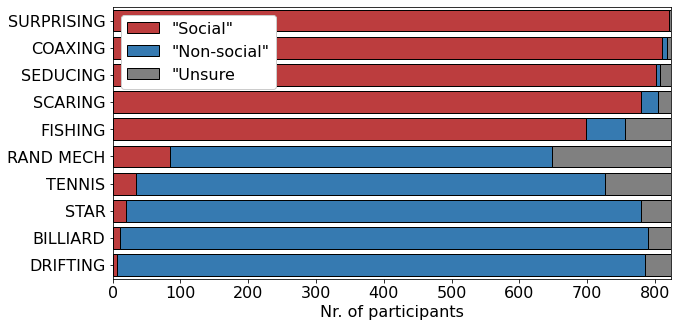

In [56]:
def plot_fig_1a(ax,counts):
    ax.barh(range(10),counts[1],color=red_rgb,label='"Social"',edgecolor='k')
    ax.barh(range(10),counts[0],left=counts[1],edgecolor='k',color=blue_rgb,label='"Non-social"')
    ax.barh(range(10),counts[9],left=counts[0]+counts[1],color='grey',edgecolor='k',label='"Unsure')

    ax.legend(loc='upper left',framealpha=1)
    #ax.legend(bbox_to_anchor=[1.01,1])
    ax.set_yticks(range(10))
    ax.set_yticklabels(vid_movie_ticks)
    ax.set_xlabel('Nr. of participants')
    #ax.set_title('Animations(least to most "Social")')
    ax.set_xlim(0,counts['sum'][0])
    ax.set_ylim(-.5,9.5)

fig = plt.figure(1,figsize=(10,5))
ax =  fig.add_subplot(111)
plot_fig_1a(ax,counts)

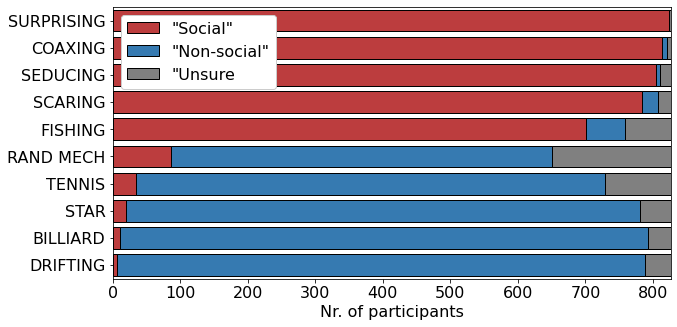

In [57]:
fig = plt.figure(1,figsize=(10,5))
ax =  fig.add_subplot(111)
plot_fig_1a(ax,counts_fullDat)

### 1(b) Number of yes/no responses per sub (for paper)

- to evaluate if there are more Yes responses than No responses on average - suggesting a Yes bias

In [79]:
counts_per_subj = data_sure.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj = counts_per_subj.unstack(level = -1)
counts_per_subj['diff'] = counts_per_subj[1]-counts_per_subj[0]
counts_per_subj['sum'] = counts_per_subj[1]+counts_per_subj[0]
counts_per_subj

response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [80]:
counts_per_subj_fullDat = data_sure_fullDat.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj_fullDat = counts_per_subj_fullDat.unstack(level = -1)
counts_per_subj_fullDat['diff'] = counts_per_subj_fullDat[1]-counts_per_subj_fullDat[0]
counts_per_subj_fullDat['sum'] = counts_per_subj_fullDat[1]+counts_per_subj_fullDat[0]
counts_per_subj_fullDat

response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [81]:
# identify NaNs
print(np.where(np.isnan(counts_per_subj)))
counts_per_subj.iloc[[60,181],:]

(array([ 60,  60,  60, 181, 181, 181]), array([0, 2, 3, 0, 2, 3]))


response,0,1,diff,sum
subj_idx,,,,
118528,NaN,9.0,NaN,NaN
153126,NaN,8.0,NaN,NaN


In [82]:
# identify NaNs
print(np.where(np.isnan(counts_per_subj_fullDat)))
counts_per_subj_fullDat.iloc[[62,183],:]

(array([ 62,  62,  62, 183, 183, 183]), array([0, 2, 3, 0, 2, 3]))


response,0,1,diff,sum
subj_idx,,,,
118528,NaN,9.0,NaN,NaN
153126,NaN,8.0,NaN,NaN


In [83]:
# relabel NaN
counts_per_subj.iloc[[60,181],0] = 0
counts_per_subj.iloc[[60,181],2] = counts_per_subj.iloc[[60,181],1]
counts_per_subj.iloc[[60,181],3] = counts_per_subj.iloc[[60,181],1]
counts_per_subj.iloc[[60,181],:]


counts_per_subj_fullDat.iloc[[62,183],0] = 0
counts_per_subj_fullDat.iloc[[62,183],2] = counts_per_subj_fullDat.iloc[[62,183],1]
counts_per_subj_fullDat.iloc[[62,183],3] = counts_per_subj_fullDat.iloc[[62,183],1]
counts_per_subj_fullDat.iloc[[62,183],:]

response,0,1,diff,sum
subj_idx,,,,
118528,0.0,9.0,9.0,9.0
153126,0.0,8.0,8.0,8.0


In [84]:
# exclude subs with 0 responses in social/nonsocial (extremes)
#rows = ~np.isnan(counts_per_subj['diff'])
#counts_per_subj = counts_per_subj.loc[rows,:]
counts_per_subj.shape, counts_per_subj_fullDat.shape

((823, 4), (826, 4))

In [85]:
# compute response perceptages and theur diiference
counts_per_subj.loc[:,'No_pc']  = 100*counts_per_subj.loc[:,0]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Yes_pc'] = 100*counts_per_subj.loc[:,1]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Soc-NonSoc_pc'] = counts_per_subj.loc[:,'Yes_pc'] - counts_per_subj.loc[:,'No_pc']
counts_per_subj

counts_per_subj_fullDat.loc[:,'No_pc']  = 100*counts_per_subj_fullDat.loc[:,0]/counts_per_subj_fullDat.loc[:,'sum']
counts_per_subj_fullDat.loc[:,'Yes_pc'] = 100*counts_per_subj_fullDat.loc[:,1]/counts_per_subj_fullDat.loc[:,'sum']
counts_per_subj_fullDat.loc[:,'Soc-NonSoc_pc'] = counts_per_subj_fullDat.loc[:,'Yes_pc'] - counts_per_subj_fullDat.loc[:,'No_pc']
counts_per_subj_fullDat

response,0,1,diff,sum,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


In [197]:
counts_per_subj.mean(),counts_per_subj.sem()

(response
 countNonSoc(No)     4.453220
 countSoc(Yes)       4.941677
 Yes-No              0.488457
 Yes+No              9.394897
 No_pc              47.107803
 Yes_pc             52.892197
 Soc-NonSoc_pc       5.784393
 dtype: float64,
 response
 countNonSoc(No)    0.033162
 countSoc(Yes)      0.024413
 Yes-No             0.051001
 Yes+No             0.028113
 No_pc              0.290525
 Yes_pc             0.290525
 Soc-NonSoc_pc      0.581051
 dtype: float64)

In [196]:
counts_per_subj_fullDat.mean(),counts_per_subj_fullDat.sem()

(response
 countNonSoc(No)     4.450363
 countSoc(Yes)       4.943099
 Yes-No              0.492736
 Yes+No              9.393462
 No_pc              47.080259
 Yes_pc             52.919741
 Soc-NonSoc_pc       5.839483
 dtype: float64,
 response
 countNonSoc(No)    0.033185
 countSoc(Yes)      0.024358
 Yes-No             0.050942
 Yes+No             0.028179
 No_pc              0.290486
 Yes_pc             0.290486
 Soc-NonSoc_pc      0.580973
 dtype: float64)

25%:50.00, 50%:50.00, 75%:55.56
25%:44.44, 50%:50.00, 75%:50.0


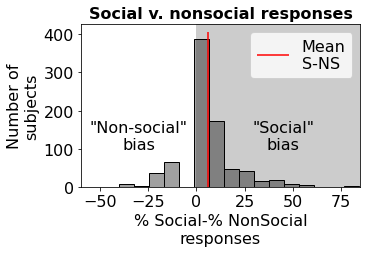

In [87]:
# informative figure, but not used in the paper
# NOT DONE FOR THE FULL DATA VERSION
fig = plt.figure(1,figsize=(5,3))
ax = fig.add_subplot(111)
sns.histplot(data=counts_per_subj,bins=20,x='Soc-NonSoc_pc',color='grey')
ax.set_xlabel('% Social-% NonSocial\nresponses')
ax.set_ylabel('Number of\nsubjects')
ymin,ymax = ax.get_ylim()
ax.vlines(counts_per_subj.mean()['Soc-NonSoc_pc'],ymin,ymax,color = 'r',label = 'Mean\nS-NS')
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.legend(loc='upper right')
ax.set_xlim(-60,85)
xmin,xmax = ax.get_ylim()
ax.axvspan(0,xmax, facecolor= '0', alpha=0.2) # background color for the first 5 bars(mental?)
ax.axvspan(xmin,0, facecolor='0.1', alpha=0.2) # background color for the first 5 bars(mental?)

ax.text(-30,100,'"Non-social"\nbias', ha='center', color = 'black')
ax.text(45,100,'"Social"\nbias', ha='center', color = 'black')
ax.set_title("Social v. nonsocial responses",fontweight='bold')
stats.ttest_1samp(counts_per_subj['Soc-NonSoc_pc'], 0)

print(f"25%:{np.quantile(counts_per_subj['Yes_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['Yes_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['Yes_pc'],.75):.2f}")
print(f"25%:{np.quantile(counts_per_subj['No_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['No_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['No_pc'],.75)}")

In [88]:
def box_plot(data, edge_color, fill_color,pos,v):
    # customize boxplots
    alpha= .2
    bp = ax.boxplot(data, positions = [pos], patch_artist=True,widths=.5,vert=v,flierprops = dict(markeredgecolor=edge_color,
    markerfacecolor=fill_color, alpha=alpha))
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for element in ['medians']:
        plt.setp(bp[element], color='k',linewidth=2,ls='dashed')
    #for element in ['fliers']:
    #    plt.setp(bp[element], marker= (5,2,0))#'*')

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=alpha)#'w'
    return bp
# exploring colors 
#import matplotlib.cm
#for i in range(len(matplotlib.cm.datad["RdBu"])):
#    print(np.array(matplotlib.cm.datad["RdBu"][i])*255)
#red_rgb = np.array(matplotlib.cm.datad["RdBu"][0])*255
#blue_rgb = np.array(matplotlib.cm.datad["RdBu"][-1])*255
#print('red:',red_rgb,',\n blue:',blue_rgb)

- asterisks convention:
- p <.05: *
- p < .01 **
- p < .001 ***
- p > .05 but  <.1 +

mean diff: 5.7843931416227905
Ttest_relResult(statistic=-9.955057612909297, pvalue=4.0348763675618627e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


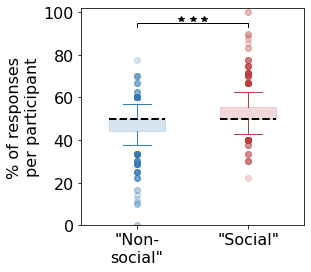

In [89]:
def plot_fig_1b(ax,counts_per_subj):
    #plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
    #ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
    bp1 = box_plot(counts_per_subj['Yes_pc'], red_rgb, red_rgb,1,True)
    bp2 = box_plot(counts_per_subj['No_pc'], blue_rgb, blue_rgb,0,True)
    #ax.set_ylim(0, 10)
    #plt.axhspan(0,50, facecolor= '0.5', alpha=0.2) # background color for the first 5 bars(mental?)
    #sns.barplot(data=counts_per_subj.loc[:,['No_pc','Yes_pc']].melt(),x='response',y='value',edgecolor = 'k',alpha=.5)
    plt.xticks(range(2),['"Non-\nsocial"','"Social"'])
    plt.ylabel("% of responses\nper participant")
    plt.ylim(0,102)
    plt.yticks([0,20,40,60,80,100])
    xmin,xmax = plt.xlim()
    plt.xlabel('')
    plt.plot([0,0,1,1],[93,95,95,93],linewidth = 1,color='k')
    plt.plot([0.4,0.5,0.6],[97]*3,'*',color='k')
    print('mean diff:',np.nanmean(counts_per_subj['Yes_pc']-counts_per_subj['No_pc']))
    print(stats.ttest_rel(counts_per_subj['No_pc'],counts_per_subj['Yes_pc']))
    print('when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!')

fig = plt.figure(figsize=(4,4))
ax =  fig.add_subplot(111)
plot_fig_1b(ax,counts_per_subj)

mean diff: 5.839482685729659
Ttest_relResult(statistic=-10.0512171700471, pvalue=1.680706301406872e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


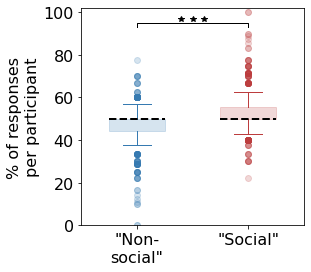

In [92]:
fig = plt.figure(figsize=(4,4))
ax =  fig.add_subplot(111)
plot_fig_1b(ax,counts_per_subj_fullDat)

In [93]:
# save data for trait analysis etc
counts_per_subj = counts_per_subj.rename(columns={0: 'countNonSoc(No)', 1: 'countSoc(Yes)','diff':'Yes-No','sum':'Yes+No'})
counts_per_subj

# save data for trait analysis etc
counts_per_subj_fullDat = counts_per_subj_fullDat.rename(columns={0: 'countNonSoc(No)', 1: 'countSoc(Yes)','diff':'Yes-No','sum':'Yes+No'})
counts_per_subj_fullDat

response,countNonSoc(No),countSoc(Yes),Yes-No,Yes+No,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


In [94]:
counts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','1b_S_NS_responses_per_subj.csv'))
counts_per_subj_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1b_S_NS_responses_per_subj_fullDat.csv'))

## 2. SDT estimates for our data

- in addition to counting one or the other responses, we can also use signal detection measures to see how they align with experimenter-assigned labels. For example, a higher number of "social" responses could show in a net(1) response bias towards social, and/or (2) an decrease in d prime (?)

In [95]:
# Function to compute SDT measures like dprime, critia etc. 
from scipy.stats import norm
import math
Z = norm.ppf
 
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

In [96]:
#creating a matrix of hits, FAs, FNs and CRs per subject

matrix = data_sure.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
matrix.head(10)

matrix_fullDat = data_sure_fullDat.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
matrix_fullDat.head(10)

response           0    1
subj_idx stim            
100206   Mental  0.0  5.0
         Random  1.0  4.0
100307   Mental  0.0  4.0
         Random  4.0  1.0
100408   Mental  0.0  5.0
         Random  4.0  0.0
100610   Mental  0.0  5.0
         Random  5.0  0.0
101309   Mental  0.0  5.0
         Random  2.0  0.0

In [97]:
hits = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits.name='hits'
misses.name='misses'
false_alarms.name='false_alarms'
correct_rejects.name='correct_rejects'

sdt_data = pd.concat([hits, misses, false_alarms, correct_rejects], axis=1)
sdt_data.head()

#sdt_data.transpose().plot(legend = None, alpha = 0.1)


hits_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects_fullDat = matrix_fullDat[matrix_fullDat.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits_fullDat.name='hits'
misses_fullDat.name='misses'
false_alarms_fullDat.name='false_alarms'
correct_rejects_fullDat.name='correct_rejects'

sdt_data_fullDat = pd.concat([hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat], axis=1)
sdt_data_fullDat.head()

#sdt_data.transpose().plot(legend = None, alpha = 0.1)

,hits,misses,false_alarms,correct_rejects
subj_idx,,,,
100206,5.0,0.0,4.0,1.0
100307,4.0,0.0,1.0,4.0
100408,5.0,0.0,0.0,4.0
100610,5.0,0.0,0.0,5.0
101309,5.0,0.0,0.0,2.0


# Creating a matrix of hits, FAs, FNs and CRs per MOVIE

In [98]:
matrix = data_sure.groupby(["movie", "response","stim"]).count()['subj_idx'].unstack(level=1).fillna(0) #/n_trials
matrix = matrix.reset_index()
matrix['total'] = matrix[0] + matrix[1]
matrix

matrix_fullDat = data_sure_fullDat.groupby(["movie", "response","stim"]).count()['subj_idx'].unstack(level=1).fillna(0) #/n_trials
matrix_fullDat = matrix_fullDat.reset_index()
matrix_fullDat['total'] = matrix[0] + matrix[1]
matrix_fullDat

response,movie,stim,0,1,total
0,BILLIARD-A.AVI,Random,781.0,11.0,789.0
1,COAXING-B.AVI,Mental,7.0,813.0,817.0
2,DRIFTING-A.AVI,Random,782.0,6.0,786.0
3,Fishing.AVI,Mental,58.0,701.0,756.0
4,Random mechanical.AVI,Random,564.0,86.0,648.0
5,SEDUCING-B.AVI,Mental,5.0,805.0,807.0
6,STAR-A.AVI,Random,761.0,20.0,779.0
7,SURPRISING-B.AVI,Mental,0.0,823.0,820.0
8,Scaring.AVI,Mental,24.0,783.0,804.0
9,TENNIS-A.AVI,Random,694.0,35.0,726.0


In [99]:
matrix['movie_ind'] = [1,0,2,3,4,6,7,8,5,9]
matrix.sort_values(by='movie_ind',inplace=True)
matrix.set_index('movie_ind',inplace=True)
matrix

matrix_fullDat['movie_ind'] = [1,0,2,3,4,6,7,8,5,9]
matrix_fullDat.sort_values(by='movie_ind',inplace=True)
matrix_fullDat.set_index('movie_ind',inplace=True)
matrix_fullDat

response,movie,stim,0,1,total
movie_ind,,,,,
0,COAXING-B.AVI,Mental,7.0,813.0,817.0
1,BILLIARD-A.AVI,Random,781.0,11.0,789.0
2,DRIFTING-A.AVI,Random,782.0,6.0,786.0
3,Fishing.AVI,Mental,58.0,701.0,756.0
4,Random mechanical.AVI,Random,564.0,86.0,648.0
5,Scaring.AVI,Mental,24.0,783.0,804.0
6,SEDUCING-B.AVI,Mental,5.0,805.0,807.0
7,STAR-A.AVI,Random,761.0,20.0,779.0
8,SURPRISING-B.AVI,Mental,0.0,823.0,820.0


In [100]:
hits, misses, false_alarms, correct_rejects = [np.empty((10,)) for _ in range(4)]
hits[:], misses[:], false_alarms[:], correct_rejects[:] = [np.nan] * 4
for i,row in matrix.iterrows():
    if row['stim'] == 'Mental':
        hits[i] = row[1]/row['total']
        misses[i] = row[0]/row['total']
    
    elif row['stim'] == 'Random':
        false_alarms[i] = row[1]/row['total']
        correct_rejects[i] = row[0]/row['total']

hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat = [np.empty((10,)) for _ in range(4)]
hits_fullDat[:], misses_fullDat[:], false_alarms_fullDat[:], correct_rejects_fullDat[:] = [np.nan] * 4
for i,row in matrix_fullDat.iterrows():
    if row['stim'] == 'Mental':
        hits_fullDat[i] = row[1]/row['total']
        misses_fullDat[i] = row[0]/row['total']
    
    elif row['stim'] == 'Random':
        false_alarms_fullDat[i] = row[1]/row['total']
        correct_rejects_fullDat[i] = row[0]/row['total']
hits_fullDat, hits

(array([0.99510404,        nan,        nan, 0.92724868,        nan,
        0.9738806 , 0.99752169,        nan, 1.00365854,        nan]),
 array([0.99143207,        nan,        nan, 0.92328042,        nan,
        0.97014925, 0.99380421,        nan, 1.        ,        nan]))

In [101]:
hits, misses, false_alarms, correct_rejects = [pd.Series(i) for i in [hits, misses, false_alarms, correct_rejects ]]
hits.name='hits'
misses.name='misses'
false_alarms.name='false_alarms'
correct_rejects.name='correct_rejects'


hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat = \
    [pd.Series(i) for i in [hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat ]]
hits_fullDat.name='hits'
misses_fullDat.name='misses'
false_alarms_fullDat.name='false_alarms'
correct_rejects_fullDat.name='correct_rejects'

In [103]:
sdt_data_movies = pd.concat([matrix['movie'],hits, misses, false_alarms, correct_rejects], axis=1)
sdt_data_movies

sdt_data_movies_fullDat = pd.concat([matrix_fullDat['movie'],hits_fullDat, misses_fullDat, false_alarms_fullDat, correct_rejects_fullDat], axis=1)
sdt_data_movies_fullDat

,movie,hits,misses,false_alarms,correct_rejects
0,COAXING-B.AVI,0.995104,0.008568,NaN,NaN
1,BILLIARD-A.AVI,NaN,NaN,0.013942,0.989861
2,DRIFTING-A.AVI,NaN,NaN,0.007634,0.994911
3,Fishing.AVI,0.927249,0.076720,NaN,NaN
4,Random mechanical.AVI,NaN,NaN,0.132716,0.870370
5,Scaring.AVI,0.973881,0.029851,NaN,NaN
6,SEDUCING-B.AVI,0.997522,0.006196,NaN,NaN
7,STAR-A.AVI,NaN,NaN,0.025674,0.976893
8,SURPRISING-B.AVI,1.003659,0.000000,NaN,NaN
9,TENNIS-A.AVI,NaN,NaN,0.048209,0.955923


In [104]:
#invoke the SDT functions + sample results for subj1
#s = 0
#SDT(sdt_data_movies["hits"].iloc[s], sdt_data_movies["misses"].iloc[s], sdt_data_movies["false_alarms"].iloc[s], sdt_data_movies["correct_rejects"].iloc[s])

- don't think we can do anuything here - for dprime a.w.a criterion, we need multiple movies since the same movie can't have hits and false alarms (whereas the same individual can have both)

In [206]:
# extracting SDT measures for each subject and saving in a dataframe
results = {}
for s, subj in enumerate(sdt_data.index.values):
    results[subj] = SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

sdt_measures = pd.DataFrame.from_dict(results, orient="index")
sdt_measures.head()

results_fullDat = {}
for s, subj in enumerate(sdt_data_fullDat.index.values):
    results_fullDat[subj] = SDT(sdt_data_fullDat["hits"].iloc[s], sdt_data_fullDat["misses"].iloc[s], \
        sdt_data_fullDat["false_alarms"].iloc[s], sdt_data_fullDat["correct_rejects"].iloc[s])

sdt_measures_fullDat = pd.DataFrame.from_dict(results_fullDat, orient="index")
sdt_measures_fullDat.head()

,d,beta,c,Ad
100206,0.439930,0.626865,-1.061586,0.622129
100307,1.991971,0.735291,-0.154364,0.920514
100408,2.431901,0.852540,-0.065601,0.957249
100610,2.563103,1.000000,-0.000000,0.965037
101309,1.956041,0.552270,-0.303531,0.916688


dat
mean: 2.3269282788643113 , sem: 0.012587219730840642
339076.0 , 6.663292598494334e-140
full dat
mean: 2.3265185118054186 ,sem: 0.012555199944471952
341551.0 , 2.1581726642417955e-140


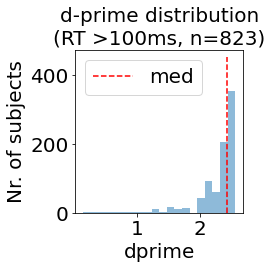

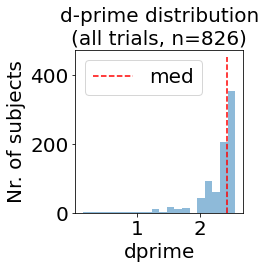

In [238]:
# Plotting the distributions of dprimes and criteria across subjects
# second figure used in the OHBM poster and paper  (1b) - this or criterion?
# not defined  this for the fulldata version

# for the reviewer in revision 1
plt.figure(1,figsize =(3,3))
sdt_measures['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('d-prime distribution\n(RT >100ms, n=823)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("dprime")
plt.legend()

print('dat\nmean:', sdt_measures['d'].mean(), ', sem:', sdt_measures['d'].sem()) # for the reviewer in revision 1
std,pdprime = stats.wilcoxon(sdt_measures['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pdprime)

plt.figure(2,figsize =(3,3))
sdt_measures_fullDat['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures_fullDat['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('d-prime distribution\n(all trials, n=826)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("dprime")
plt.legend()

print('full dat\nmean:',sdt_measures_fullDat['d'].mean(), ',sem:', sdt_measures_fullDat['d'].sem()) # for the reviewer in revision 1
std,pdprime = stats.wilcoxon(sdt_measures_fullDat['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pdprime)


dat
mean: 0.9545053541793677 , sem: 0.008846875340468362
339076.0 , 4.4562663326571415e-140
dat
mean: 0.9536768051715554 , sem: 0.008837223845901677
341551.0 , 1.441437161773569e-140


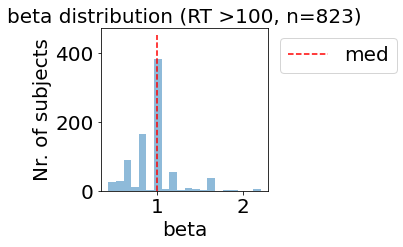

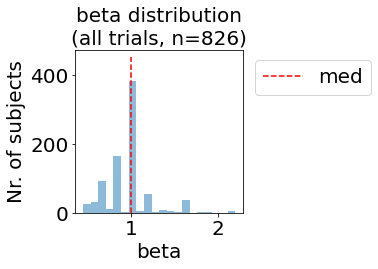

In [242]:
# for reviewer 2 in revision 1

plt.figure(1,figsize =(3,3))
sdt_measures['beta'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['beta']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('beta distribution (RT >100, n=823)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("beta")
plt.legend(bbox_to_anchor = [1.01,1])

print('dat\nmean:', sdt_measures['beta'].mean(), ', sem:', sdt_measures['beta'].sem()) # for the reviewer in revision 1
std,pbeta = stats.wilcoxon(sdt_measures['beta'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pbeta)

# for reviewer 2 in revision 1

plt.figure(2,figsize =(3,3))
sdt_measures_fullDat['beta'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures_fullDat['beta']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "med")
plt.title('beta distribution\n(all trials, n=826)')
plt.grid(None)
plt.ylabel('Nr. of subjects')
plt.xlabel("beta")
plt.legend(bbox_to_anchor = [1.01,1])

print('dat\nmean:', sdt_measures_fullDat['beta'].mean(), ', sem:', sdt_measures_fullDat['beta'].sem()) # for the reviewer in revision 1
std,pbeta = stats.wilcoxon(sdt_measures_fullDat['beta'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pbeta)

In [214]:
sdt_measures['c'].mean(), sdt_measures['c'].sem() # for paper

(-0.047036516250207085, 0.005934396318923674)

In [208]:
sdt_measures_fullDat['c'].mean(), sdt_measures_fullDat['c'].sem() # for revision 1

(-0.047499453931695565, 0.005924944659365216)

26813.5 , 1.0623685894361655e-18 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


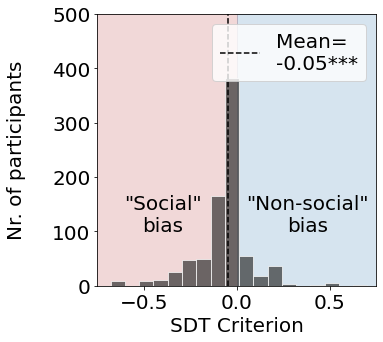

In [210]:
def plot_fig_1c(ax,sdt_measures):

    stc, pc = stats.wilcoxon(sdt_measures['c'])
    print(stc,',',pc, 'when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!')

    #plt.title('Response bias', fontweight = 'bold')
    ax.axvspan(-1,0,color=red_rgb,alpha=alpha)
    ax.axvspan(0,1,color=blue_rgb,alpha=alpha)
    #sns.distplot(sdt_measures['c'], bins= 30, label = 'criterion bias across subjects', norm_hist = False)
    sdt_measures['c'].hist(bins=25, alpha = .7, color = [.2,.2,.2],edgecolor = 'white')
    #plt.vlines(np.nanmean(sdt_measures['c']),0,500,color='r', linewidth = 3,linestyle = 'solid',
    #           label = f'mean={np.round(np.nanmean(sdt_measures["c"]),2)},\np(Wilc.)=\n{1.9e-26}')
    ax.vlines(np.nanmean(sdt_measures['c']),0,500,color='k', linestyle = 'dashed',
            label = f"Mean=\n{np.round(np.nanmean(sdt_measures['c']),2)}***")# \n"r"(p<$10^{-18}$)"

            #plt.plot(np.zeros((10,1)), np.linspace(0,450,10),\
    #         'grey', linestyle = 'dashed',label = f'0(No bias)')

    ax.grid(None)
    ax.set_ylabel('Nr. of participants\n ')
    ax.set_xlabel("SDT Criterion")
    ax.set_xlim(-.75,.75)
    ax.set_ylim(0,500)
    #plt.xticks([-.75,-.5,-.25,0,.25,.5,.75], rotation=30)
    #plt.legend(fontsize = 14,bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.legend()#bbox_to_anchor = (1.05,1))

    ax.text(-.4,100,'"Social"\nbias', ha='center',  color = 'k')
    ax.text(.38,100,'"Non-social"\nbias', ha='center', color = 'k')

    #plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)
plot_fig_1c(ax,sdt_measures)

26834.0 , 4.435764321171681e-19 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!


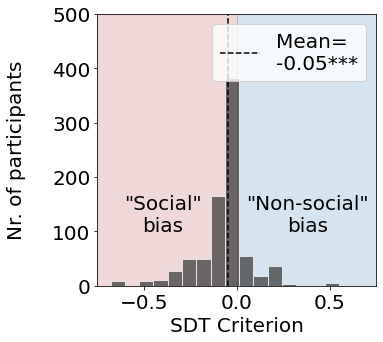

In [211]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)
plot_fig_1c(ax,sdt_measures_fullDat)

In [114]:
# save data for trait analysis etc
sdt_measures.to_csv(os.path.join(file_loc,'data_for_paper','1c_SDTmeasures_per_subj.csv'))
sdt_measures_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1c_SDTmeasures_per_subj_fulldata.csv'))

# LMEs

In [115]:
# LME:

# We use the Python version called pymer4 of the R package lme4.

#from pymer4.test_install import test_install; test_install() # to test pyme4r install
# important: pymer installed in the conda environment py37 (python v3.7x), 
# so if module can't be found here, quit Jupyter and type 'conda activate py37' into terminal

#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm

- Subject and stimulus being random factors that could've influenced results, it's important to control for them. LMEM lets us control for their effects on the DV using random intercepts and sometimes also on how the regressors affect the DV (using random slopes). The following cells show various LMEMs.

Interpreting the logistic regression results : if coef= .379
log(p(r=1)/p(r=0)) = .379 So p(r=1)/p(r=0) = exp(.379) > 1, so p(r=1) is more likely, BUT p-value = 0.749 so results are not significant.

## Reaction time

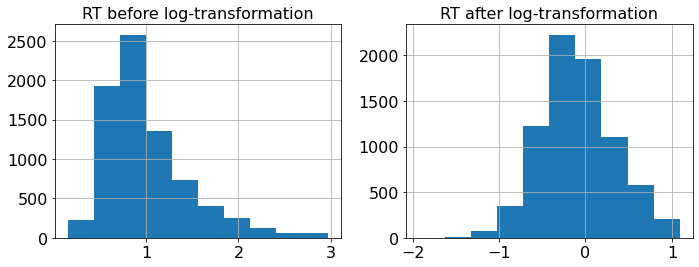

In [116]:
#log-transforming RT makes the distribution closer to a Gaussian
data_sure = data_sure.assign(logRT = np.log(data_sure['rt'])) # add a column for logRT
data_sure.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure['logRT'].hist()
plt.tight_layout()

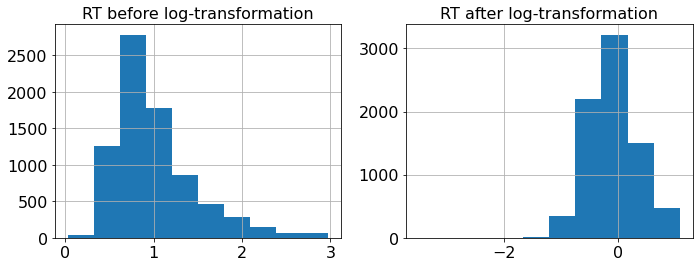

In [130]:
#log-transforming RT makes the distribution closer to a Gaussian
data_sure_fullDat.loc[data_sure_fullDat['rt']==0,'rt'] = np.nan
data_sure_fullDat = data_sure_fullDat.assign(logRT = np.log(data_sure_fullDat['rt'])) # add a column for logRT
data_sure_fullDat.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure_fullDat['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure_fullDat['logRT'].hist()
plt.tight_layout()

- Most of the analyses will be done on the sure responses.
- RT is skewed and hence we take its log-transform (still not fully normal)

<font color=red> TODO sometime: Look for the best family of distribution for RT (better than log) potentially using KL divergence, shift to glmer function and perhaps R </font>

## Qn: Are "social" responses faster than "nonsocial" responses?

- asterisks convention:
- p <.05: *
- p < .01 **
- p < .001 ***
- p > .05 but  <.1 +

Observer responses as labels:
test stat= 144885.0 , p= 0.0005566263911873042


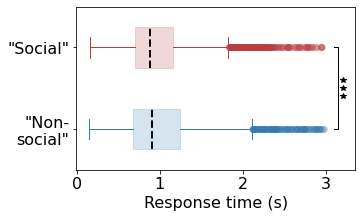

In [132]:
def plot_fig_1d(ax, p_rt):

    #rt_per_resptype_mean = data_sure.groupby(['response']).mean().rt
    #rt_per_resptype_sem = data_sure.groupby(['response']).sem().rt

    #plt.figure(1, figsize=(5,2))
    #plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
    #ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
    bp1 = box_plot(data_sure.loc[data_sure['response']==1,'rt'], red_rgb, red_rgb,1,False)
    bp2 = box_plot(data_sure.loc[data_sure['response']==0,'rt'], blue_rgb, blue_rgb,0,False)

    #rts_per_subj = data_sure.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
    #rts_per_subj['diff'] = rts_per_subj[1]-rts_per_subj[0]
    ax.set_yticks(range(2))
    ax.set_yticklabels(('"Non-\nsocial"','"Social"'))
    ax.set_ylabel('')
    ax.set_xlabel('Response time (s)')
    ax.plot([3.1,3.15,3.15,3.1],[0,0,1,1],color='k', linewidth=1)

    if p_rt < .001:
        plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt < .01:
        plt.plot([3.2]*2,[.45,.55],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt < .05:
        plt.plot([3.2]*1,[.5],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3#return rts_per_subj

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj = data_sure.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj['diff'] = rts_per_subj[1]-rts_per_subj[0]

rts_per_subj.dropna(inplace=True) # remove NaN rows
rts_per_subj = rts_per_subj.rename(columns={0: 'medianRT_NonSoc(No)', 1: 'medianRT_Soc(Yes)','diff':'medianYes-medianNo'})
st_rt, p_rt = stats.wilcoxon(rts_per_subj['medianRT_Soc(Yes)'],rts_per_subj['medianRT_NonSoc(No)'])#rts_per_subj['diff'])
print('Observer responses as labels:\ntest stat=',st_rt,', p=',p_rt)

plot_fig_1d(ax, p_rt)


In [217]:
rts_per_subj.median(), rts_per_subj.sem()

(response
 medianRT_NonSoc(No)    0.900
 medianRT_Soc(Yes)      0.870
 medianYes-medianNo    -0.023
 dtype: float64,
 response
 medianRT_NonSoc(No)    0.011850
 medianRT_Soc(Yes)      0.009195
 medianYes-medianNo     0.011437
 dtype: float64)

Observer responses as labels:
test stat= 145488.0 , p= 0.00042281593662054994


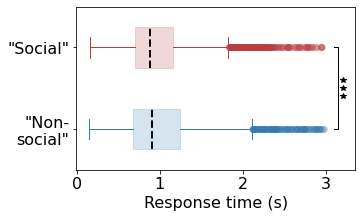

In [134]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_fullDat = data_sure_fullDat.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_fullDat['diff'] = rts_per_subj_fullDat[1]-rts_per_subj_fullDat[0]

rts_per_subj_fullDat.dropna(inplace=True) # remove NaN rows
rts_per_subj_fullDat = rts_per_subj_fullDat.rename(columns={0: 'medianRT_NonSoc(No)', 1: 'medianRT_Soc(Yes)','diff':'medianYes-medianNo'})
st_rt_fullDat, p_rt_fullDat = stats.wilcoxon(rts_per_subj_fullDat['medianRT_Soc(Yes)'],rts_per_subj_fullDat['medianRT_NonSoc(No)'])#rts_per_subj['diff'])
print('Observer responses as labels:\ntest stat=',st_rt_fullDat,', p=',p_rt_fullDat)

plot_fig_1d(ax, p_rt_fullDat)

In [218]:
rts_per_subj_fullDat.median(),rts_per_subj_fullDat.sem()

(response
 medianRT_NonSoc(No)    0.9005
 medianRT_Soc(Yes)      0.8695
 medianYes-medianNo    -0.0230
 dtype: float64,
 response
 medianRT_NonSoc(No)    0.011816
 medianRT_Soc(Yes)      0.009173
 medianYes-medianNo     0.011414
 dtype: float64)

Experimenter labels:
test stat= 142604.0 , p= 0.00012223828267660035


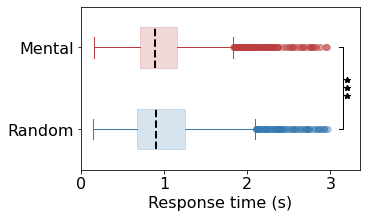

In [135]:
def plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom):

    #rt_per_resptype_mean = data_sure.groupby(['response']).mean().rt
    #rt_per_resptype_sem = data_sure.groupby(['response']).sem().rt

    #plt.figure(1, figsize=(5,2))
    #plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
    #ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
    bp1 = box_plot(data_sure.loc[data_sure['stim']=='Mental','rt'], red_rgb, red_rgb,1,False)
    bp2 = box_plot(data_sure.loc[data_sure['stim']=='Random','rt'], blue_rgb, blue_rgb,0,False)

    ax.set_yticks(range(2))
    ax.set_yticklabels(('Random','Mental'))
    ax.set_ylabel('')
    ax.set_xlabel('Response time (s)')
    ax.plot([3.1,3.15,3.15,3.1],[0,0,1,1],color='k', linewidth=1)

    if p_rt_MentalRandom < .001:
        plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt_MentalRandom < .01:
        plt.plot([3.2]*2,[.45,.55],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3
    elif p_rt_MentalRandom < .05:
        plt.plot([3.2]*1,[.5],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3#return rts_per_subj


    plt.plot([3.2]*3,[.5,.4,.6],'*',color='k') # 3 asterisks based on the paired Wilcoxon test which had p< 10^-3

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_MentalRandom = data_sure.groupby(['subj_idx', 'stim']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_MentalRandom['diff'] = rts_per_subj_MentalRandom['Mental']-rts_per_subj_MentalRandom['Random']

rts_per_subj_MentalRandom.dropna(inplace=True) # remove NaN rows
rts_per_subj_MentalRandom = rts_per_subj_MentalRandom.rename(columns={'Random': 'medianRT_Random', 'Mental': 'medianRT_Mental','diff':'medianMental-medianRandom'})
st_rt_MentalRandom, p_rt_MentalRandom = stats.wilcoxon(rts_per_subj_MentalRandom['medianRT_Mental'],rts_per_subj_MentalRandom['medianRT_Random'])#rts_per_subj['diff'])
print('Experimenter labels:\ntest stat=',st_rt_MentalRandom,', p=',p_rt_MentalRandom)

plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom)

Experimenter labels:
test stat= 143352.0 , p= 9.949081293607178e-05


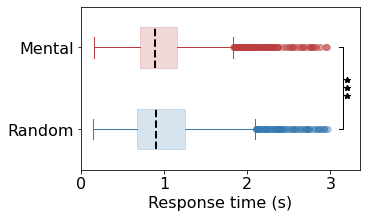

In [137]:

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj_MentalRandom_fullDat = data_sure_fullDat.groupby(['subj_idx', 'stim']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
rts_per_subj_MentalRandom_fullDat['diff'] = rts_per_subj_MentalRandom_fullDat['Mental']-rts_per_subj_MentalRandom_fullDat['Random']

rts_per_subj_MentalRandom_fullDat.dropna(inplace=True) # remove NaN rows
rts_per_subj_MentalRandom_fullDat = rts_per_subj_MentalRandom_fullDat.rename(columns={'Random': 'medianRT_Random', 'Mental': 'medianRT_Mental','diff':'medianMental-medianRandom'})
st_rt_MentalRandom_fullDat, p_rt_MentalRandom_fullDat = stats.wilcoxon(rts_per_subj_MentalRandom_fullDat['medianRT_Mental'],rts_per_subj_MentalRandom_fullDat['medianRT_Random'])#rts_per_subj['diff'])
print('Experimenter labels:\ntest stat=',st_rt_MentalRandom_fullDat,', p=',p_rt_MentalRandom_fullDat)

plot_fig_1d_MentalRandom(ax,p_rt_MentalRandom_fullDat)


In [216]:
rts_per_subj_MentalRandom.mean()

stim
medianRT_Mental              0.916100
medianRT_Random              0.967869
medianMental-medianRandom   -0.051769
dtype: float64

In [139]:


# identify NaN rows
print(np.where(np.isnan(rts_per_subj_MentalRandom)))
print(rts_per_subj_MentalRandom.iloc[[60,181],:])
rts_per_subj_MentalRandom.shape

#print(st_rt,',',p_rt,np.nanmean(rts_per_subj_MentalRandom['medianMental-medianRandom']))
#rts_per_subj_MentalRandom.median(),rts_per_subj_MentalRandom.sem()

(array([], dtype=int64), array([], dtype=int64))
stim      medianRT_Mental  medianRT_Random  medianMental-medianRandom
subj_idx                                                             
118528              0.856           1.2375                    -0.3815
153126              0.859           0.7720                     0.0870


(823, 3)

In [141]:
# so overall, there's no difference between Mental/Random and Social/Non-social above, but these use medians per subject
# how about sem?
# SEM social/nonsocial
'''sem_rt_per_subj = data_sure.groupby(['subj_idx', 'response']).sem().rt.unstack(level=-1) # Mean count per subject for Mental and Random
sem_rt_per_subj = sem_rt_per_subj.rename(columns={0: 'semRT_NonSoc(No)', 1: 'semRT_Soc(Yes)'})
sem_st_rt, sem_p_rt = stats.wilcoxon(sem_rt_per_subj['semRT_Soc(Yes)'],sem_rt_per_subj['semRT_NonSoc(No)'])#rts_per_subj['diff'])
sem_st_rt, sem_p_rt, sem_rt_per_subj['semRT_Soc(Yes)'].mean(),sem_rt_per_subj['semRT_NonSoc(No)'].mean()'''

"sem_rt_per_subj = data_sure.groupby(['subj_idx', 'response']).sem().rt.unstack(level=-1) # Mean count per subject for Mental and Random\nsem_rt_per_subj = sem_rt_per_subj.rename(columns={0: 'semRT_NonSoc(No)', 1: 'semRT_Soc(Yes)'})\nsem_st_rt, sem_p_rt = stats.wilcoxon(sem_rt_per_subj['semRT_Soc(Yes)'],sem_rt_per_subj['semRT_NonSoc(No)'])#rts_per_subj['diff'])\nsem_st_rt, sem_p_rt, sem_rt_per_subj['semRT_Soc(Yes)'].mean(),sem_rt_per_subj['semRT_NonSoc(No)'].mean()"

In [142]:
# SEM mental/random
'''sem_rt_per_subj_MentalRandom = data_sure.groupby(['subj_idx', 'stim']).sem().rt.unstack(level=-1) # Mean count per subject for Mental and Random
sem_rt_per_subj_MentalRandom = sem_rt_per_subj_MentalRandom.rename(columns={'Random': 'semRT_Random', 'Mental': 'semRT_Mental'})
sem_st_rt_MentalRandom, sem_p_rt_MentalRandom = stats.wilcoxon(sem_rt_per_subj_MentalRandom['semRT_Mental'],sem_rt_per_subj_MentalRandom['semRT_Random'])
#rts_per_subj['diff'])
sem_st_rt_MentalRandom, sem_p_rt_MentalRandom, sem_rt_per_subj_MentalRandom['semRT_Mental'].mean(), sem_rt_per_subj_MentalRandom['semRT_Random'].mean()'''

"sem_rt_per_subj_MentalRandom = data_sure.groupby(['subj_idx', 'stim']).sem().rt.unstack(level=-1) # Mean count per subject for Mental and Random\nsem_rt_per_subj_MentalRandom = sem_rt_per_subj_MentalRandom.rename(columns={'Random': 'semRT_Random', 'Mental': 'semRT_Mental'})\nsem_st_rt_MentalRandom, sem_p_rt_MentalRandom = stats.wilcoxon(sem_rt_per_subj_MentalRandom['semRT_Mental'],sem_rt_per_subj_MentalRandom['semRT_Random'])\n#rts_per_subj['diff'])\nsem_st_rt_MentalRandom, sem_p_rt_MentalRandom, sem_rt_per_subj_MentalRandom['semRT_Mental'].mean(), sem_rt_per_subj_MentalRandom['semRT_Random'].mean()"

In [144]:
# save data for trait analysis etc
data_sure.to_csv(os.path.join(file_loc,'data_for_paper','1d_sure_responses.csv'),index=False)
data_sure_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1d_sure_responses_fullDat.csv'),index=False)
rts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','extra_medianRT_per_subj.csv'))
rts_per_subj_MentalRandom.to_csv(os.path.join(file_loc,'data_for_paper','extra_medianRT_per_subj_MentalRandom.csv'))

In [ ]:
# other optional figure if needed later
plt.figure(1, figsize=(6,2))
data = rts_per_subj['medianYes-medianNo'].values
data  = data[~np.isnan(data)]
_, bins, _ = plt.hist(data, 20, density=1, alpha=0.5,color = 'grey', align = 'mid',edgecolor = 'k')
mu, sigma = scipy.stats.norm.fit(data)
xpts = np.linspace(-1.5,1,20)
best_fit_line = scipy.stats.norm.pdf(xpts, mu, sigma)
plt.plot(xpts, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [0.5,0.2])

plt.figure(2, figsize=(8,2))
sns.boxplot(x=data)
ymin,ymax = plt.ylim()
#plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')


## LMEs

In [145]:
# subs who only responded "Social" or "Non-social" can make the LME fail to converge, hence removing these subs from both the analyses

nresps_per_resp = data_sure.groupby(['subj_idx','response']).count().unstack(level=1).iloc[:,:2]
nresps_per_resp.columns = nresps_per_resp.columns.droplevel()
nresps_per_resp
biased_sub_IDs = list(nresps_per_resp[nresps_per_resp[0].isna()].index)
biased_sub_IDs

data_sure_nobiasedsubs = data_sure.loc[(data_sure['subj_idx'] != biased_sub_IDs[0])&(data_sure['subj_idx'] != biased_sub_IDs[1]),:]
print(data_sure_nobiasedsubs.shape, data_sure.shape)



# same as above, but for all data without removing rt<100ms
nresps_per_resp_fullDat = data_sure_fullDat.groupby(['subj_idx','response']).count().unstack(level=1).iloc[:,:2]
nresps_per_resp_fullDat.columns = nresps_per_resp_fullDat.columns.droplevel()
nresps_per_resp_fullDat
biased_sub_IDs_fullDat = list(nresps_per_resp_fullDat[nresps_per_resp_fullDat[0].isna()].index)
biased_sub_IDs_fullDat

data_sure_nobiasedsubs_fullDat = data_sure_fullDat.loc[(data_sure_fullDat['subj_idx'] != biased_sub_IDs_fullDat[0])&\
    (data_sure_fullDat['subj_idx'] != biased_sub_IDs_fullDat[1]),:]
data_sure_nobiasedsubs_fullDat.shape, data_sure_fullDat.shape

(7715, 8) (7732, 8)


((7742, 8), (7759, 8))

In [149]:
np.where(np.isnan(data_sure_fullDat['rt']))

(array([5971]),)

# Only random intercepts


Formula: logRT~response+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7732	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -3117.835 	 AIC: 6235.670

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.029  0.171
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.066  -0.176    0.044  0.056    10.126  -1.175  0.267    
response       -0.037  -0.081    0.008  0.023  3509.453  -1.626  0.104    


NormaltestResult(statistic=287.54123357855724, pvalue=3.6409479346292417e-63)

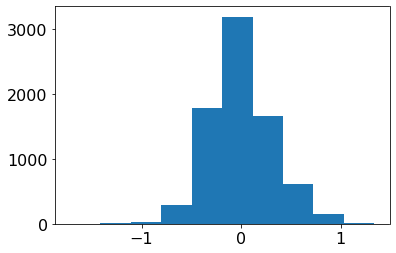

In [147]:
# USED IN THE PAPER!! (but using data_sure)
model = Lmer('logRT ~  response +(1|subj_idx) + (1|movie)', data=data_sure)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

#data_sure['response_txt'] = data_sure.apply(lambda row: "Social" if row.response==1 else "Non-social",axis=1)
#data_sure.head()

#Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough
#- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

In [150]:
data_sure_fullDat_nonan = data_sure_fullDat.loc[~np.isnan(data_sure_fullDat['rt']),:]
data_sure_fullDat_nonan.shape,data_sure_fullDat.shape

((7758, 8), (7759, 8))

Formula: logRT~response+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7758	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3205.671 	 AIC: 6411.343

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.029  0.170
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.065  -0.175    0.044  0.056    10.150  -1.172  0.268    
response       -0.040  -0.085    0.005  0.023  3415.352  -1.755  0.079   .


NormaltestResult(statistic=472.27147664442975, pvalue=2.8025403008216897e-103)

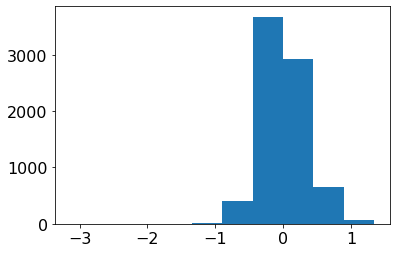

In [152]:
model = Lmer('logRT ~  response +(1|subj_idx) + (1|movie)', data=data_sure_fullDat_nonan)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7732	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -3117.557 	 AIC: 6235.114

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.033  0.181
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.079  -0.238    0.081  0.081  8.129  -0.966  0.362    
stim1          -0.012  -0.237    0.213  0.115  8.002  -0.103  0.920    


NormaltestResult(statistic=287.7385573507574, pvalue=3.298877249791852e-63)

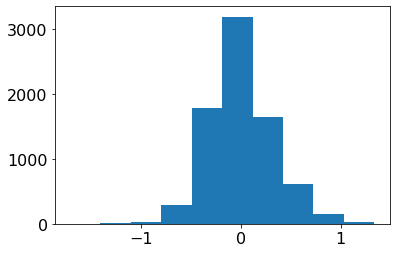

In [153]:
# for the first revision, repeat model with stimtype 
# MENTAL/RANDOM version in first revision
model = Lmer('logRT ~  stim +(1|subj_idx) + (1|movie)', data=data_sure)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= modelb
# .data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7758	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3205.622 	 AIC: 6411.245

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.032  0.180
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.079  -0.238     0.08  0.081  8.130  -0.975  0.357    
stim1          -0.014  -0.237     0.21  0.114  8.002  -0.118  0.909    


NormaltestResult(statistic=472.12339452121074, pvalue=3.0179183866444107e-103)

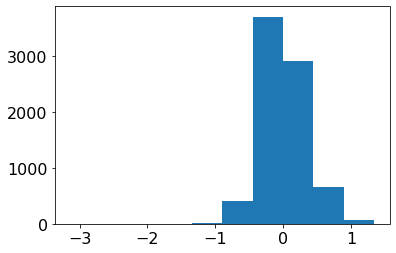

In [154]:
# for the first revision, repeat model with stimtype 
# MENTAL/RANDOM version in first revision
model = Lmer('logRT ~  stim +(1|subj_idx) + (1|movie)', data=data_sure_fullDat_nonan)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= modelb
# .data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7732	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -3119.070 	 AIC: 6238.140

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.033  0.181
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.077  -0.237    0.083  0.081     8.132  -0.945  0.372    
response       -0.038  -0.083    0.007  0.023  7304.410  -1.636  0.102    
stim1           0.023  -0.206    0.252  0.117     8.570   0.199  0.847    


NormaltestResult(statistic=287.61162948765747, pvalue=3.5150231622866255e-63)

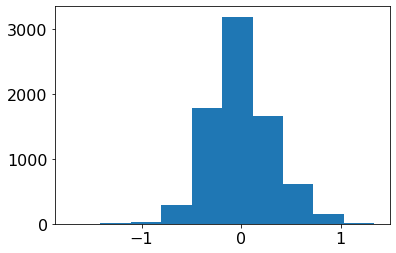

In [155]:
model = Lmer('logRT ~  response + stim + (1|subj_idx) + (1|movie)', data=data_sure)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

#Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough
#- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

Formula: logRT~response+stim+(1|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7758	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3206.908 	 AIC: 6413.816

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.042  0.205
movie     (Intercept)  0.032  0.180
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.077  -0.236    0.082  0.081     8.134  -0.952  0.368    
response       -0.041  -0.087    0.005  0.023  7332.974  -1.764  0.078   .
stim1           0.025  -0.203    0.252  0.116     8.587   0.212  0.837    


NormaltestResult(statistic=472.37945013099693, pvalue=2.6552518604513225e-103)

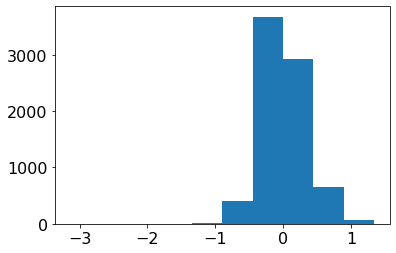

In [156]:
model = Lmer('logRT ~  response + stim + (1|subj_idx) + (1|movie)', data=data_sure_fullDat_nonan)#data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)


# RIs+  RS

Formula: logRT~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7715	 Groups: {'subj_idx': 821.0, 'movie': 10.0}

Log-likelihood: -3067.738 	 AIC: 6135.476

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.061  0.247
subj_idx     response  0.023  0.152
movie     (Intercept)  0.030  0.172
Residual               0.104  0.323

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.612

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.065  -0.175    0.045  0.056    10.259  -1.156  0.274    
response       -0.036  -0.081    0.009  0.023  3516.958  -1.559  0.119    


NormaltestResult(statistic=298.44578507059236, pvalue=1.560706353233092e-65)

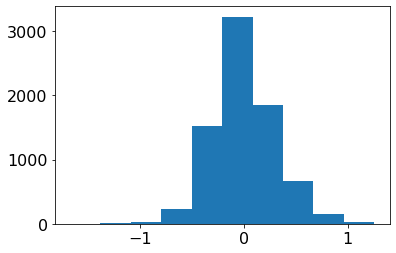

In [157]:
model = Lmer('logRT ~  response + (response|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

#Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough
#- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

In [159]:
data_sure_nobiasedsubs_fullDat_nonan = data_sure_nobiasedsubs_fullDat.loc[~np.isnan(data_sure_nobiasedsubs_fullDat['rt']),:]
data_sure_nobiasedsubs_fullDat_nonan.shape, data_sure_nobiasedsubs_fullDat.shape

((7741, 8), (7742, 8))

Formula: logRT~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7741	 Groups: {'subj_idx': 824.0, 'movie': 10.0}

Log-likelihood: -3158.014 	 AIC: 6316.028

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.060  0.245
subj_idx     response  0.024  0.153
movie     (Intercept)  0.029  0.171
Residual               0.107  0.327

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.594

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.064  -0.174    0.045  0.056    10.279  -1.149  0.277    
response       -0.040  -0.085    0.006  0.023  3426.064  -1.701  0.089   .


NormaltestResult(statistic=512.184476457225, pvalue=6.033288307440422e-112)

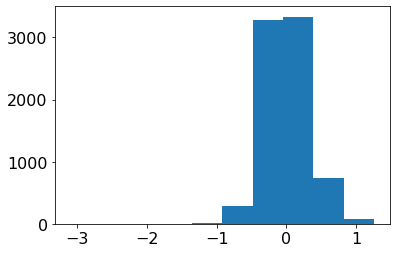

In [161]:
model = Lmer('logRT ~  response + (response|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs_fullDat_nonan) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

#Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough
#- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

In [166]:
stats.spearmanr(data_sure_nobiasedsubs['stim'],data_sure_nobiasedsubs['response_txt'])

SpearmanrResult(correlation=-0.9367337668366813, pvalue=0.0)

Formula: logRT~response+stim+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7715	 Groups: {'subj_idx': 821.0, 'movie': 10.0}

Log-likelihood: -3068.976 	 AIC: 6137.952

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.061  0.247
subj_idx     response  0.023  0.152
movie     (Intercept)  0.033  0.181
Residual               0.104  0.323

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.612

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.075  -0.235    0.086  0.082     8.192  -0.914  0.387    
response       -0.037  -0.083    0.009  0.024  6610.477  -1.565  0.118    
stim1           0.020  -0.209    0.250  0.117     8.572   0.173  0.866    


NormaltestResult(statistic=298.49070231219383, pvalue=1.5260457130123397e-65)

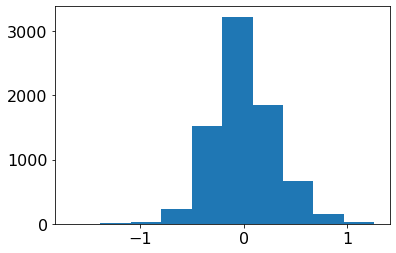

In [162]:
model = Lmer('logRT ~  response + stim + (response|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

#Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough
#- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

Formula: logRT~response+stim+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7741	 Groups: {'subj_idx': 824.0, 'movie': 10.0}

Log-likelihood: -3159.253 	 AIC: 6318.506

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.060  0.245
subj_idx     response  0.024  0.153
movie     (Intercept)  0.033  0.180
Residual               0.107  0.327

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.594

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.075  -0.234    0.084  0.081     8.187  -0.922  0.383    
response       -0.041  -0.087    0.006  0.024  6629.687  -1.708  0.088   .
stim1           0.022  -0.206    0.250  0.116     8.585   0.190  0.854    


NormaltestResult(statistic=512.273983188707, pvalue=5.7692311436818605e-112)

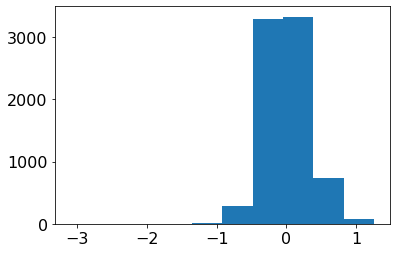

In [163]:
model = Lmer('logRT ~  response + stim + (response|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs_fullDat_nonan) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)


Formula: logRT~stim+(stim|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7715	 Groups: {'subj_idx': 821.0, 'movie': 10.0}

Log-likelihood: -3074.896 	 AIC: 6149.792

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.059  0.243
subj_idx   stimMental  0.019  0.139
movie     (Intercept)  0.033  0.181
Residual               0.105  0.325

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.612

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val Sig
(Intercept)    -0.077  -0.238    0.083  0.082  8.18  -0.946  0.371    
stim1          -0.013  -0.239    0.212  0.115  8.03  -0.114  0.912    


NormaltestResult(statistic=298.83471991995896, pvalue=1.2848873956119485e-65)

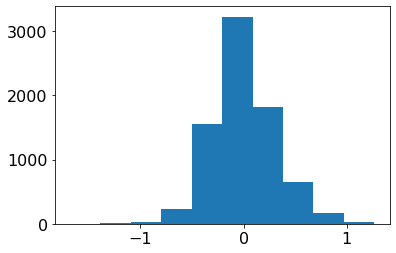

In [164]:
# for the first revision, repeat model with stimtype 
# MENTAL/RANDOM version in first revision
model = Lmer('logRT ~  stim +(stim|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~stim+(stim|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7741	 Groups: {'subj_idx': 824.0, 'movie': 10.0}

Log-likelihood: -3165.094 	 AIC: 6330.188

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.059  0.242
subj_idx   stimMental  0.020  0.140
movie     (Intercept)  0.033  0.180
Residual               0.108  0.328

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.594

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     DF  T-stat  P-val Sig
(Intercept)    -0.078  -0.237    0.082  0.081  8.180  -0.955  0.367    
stim1          -0.015  -0.239    0.209  0.114  8.031  -0.129  0.900    


NormaltestResult(statistic=510.03628882750866, pvalue=1.766148008309569e-111)

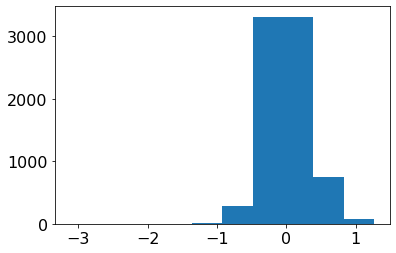

In [165]:
# for the first revision, repeat model with stimtype 
# MENTAL/RANDOM version in first revision
model = Lmer('logRT ~  stim +(stim|subj_idx) + (1|movie)', data=data_sure_nobiasedsubs_fullDat_nonan) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

In [169]:
'''model = Lmer('logRT ~  response +(response|subj_idx)', data=data_sure_nobiasedsubs) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.boxplot(model.residuals)
stat,p=stats.normaltest(model.residuals)
ymin,ymax=plt.ylim()
#print(np.nanmean(model.residuals))
#plt.vlines(np.nanmean(model.residuals),ymin,ymax,color='k',label=f'mean={np.nanmean(model.residuals):.3f}')
plt.title(f'Residuals from\nlogRT ~  response +(response|subj_idx)\nnormality test stat={stat:.2f},p={p:.1e}')
#plt.legend()'''

'''model = Lmer('rt ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)'''

'''model = Lmer('rt ~  response +(response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals)
plt.boxplot(model.residuals)
ymin,ymax=plt.ylim()
#plt.vlines(np.nanmean(model.residuals),ymin,ymax,color='k',label=f'mean={np.nanmean(model.residuals):.3f}')
stat,p=stats.normaltest(model.residuals)
plt.title(f'Residuals from\nrt ~  response +(response|subj_idx)\nnormality test stat={stat:.2f},p={p:.2e}')
#plt.legend()'''

'''model = Lmer('logRT ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)'''

'''# MENTAL/RANDOM version in first revision (but wihout log-transforming RT)
model = Lmer('rt ~  stim +(1|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)'''

'''# MENTAL/RANDOM version in first revision
model = Lmer('rt ~  response +(1|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)
'''

"# MENTAL/RANDOM version in first revision\nmodel = Lmer('rt ~  response +(1|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID\nprint(model.fit())\n#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)\nplt.hist(model.residuals)\nstats.normaltest(model.residuals)\n"

## 3. Uncertainty analyses

In [170]:
'''thresh = 10
trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)'''


'thresh = 10\ntrial_counts = dat.groupby("subj_idx").count()["rt"]\nbad_subs = trial_counts[(trial_counts < thresh)].index\n#print(bad_subs)\ndat  = dat.reset_index() # add index as an additional column "index"\ndat = dat.set_index(\'subj_idx\') # make subj_idx the index\ndat.drop(bad_subs, inplace=True) # remove bad subjects\ndat = dat.reset_index() #bring back subj_idx as a column\ndat = dat.set_index(\'index\') # make the column "index" as the index (as in the beginning)\n\nprint("Nr. of subjects left",len(dat.groupby("subj_idx")))\nprint("Nr. of rows:",dat.shape)'

In [171]:
certainty = np.ones(len(dat['response']))
certainty = [1 if i != 9 else 0 for i in dat['response'].values]
dat['certainty'] = certainty
uncertainty = [0 if i != 9 else 1 for i in dat['response'].values]
dat['uncertainty'] = uncertainty

#dat = dat.assign(certainty)
dat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind,certainty,uncertainty
index,,,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,2,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,3,1,0


In [172]:
certainty_fullDat = np.ones(len(fullDat['response']))
certainty_fullDat = [1 if i != 9 else 0 for i in fullDat['response'].values]
fullDat['certainty'] = certainty_fullDat
uncertainty_fullDat = [0 if i != 9 else 1 for i in fullDat['response'].values]
fullDat['uncertainty'] = uncertainty_fullDat

#dat = dat.assign(certainty)
fullDat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind,certainty,uncertainty
index,,,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,2,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,3,1,0


before: (823, 2)
after: (823, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


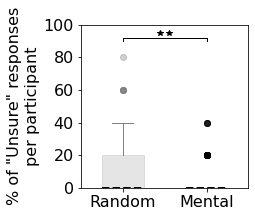

In [173]:
def plot_fig_1e(ax,summary):
    cols = summary.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    summary = summary[cols]
    print('before:',summary.shape)
    summary = summary.loc[(~np.isnan(summary['Random'])&(~np.isnan(summary['Mental']))),:]
    print('after:',summary.shape)
    mn = summary.mean()
    sem = summary.sem()

    bp1 = box_plot(summary['Random'], 'grey', 'grey',0,True)
    bp2 = box_plot(summary['Mental'], 'black', 'black',1,True)
    
    #Figure 1c in the submitted OHBM abstract
    #sns.barplot(data=summary,alpha=.5,edgecolor='k')
    plt.xticks((0,1),('Random','Mental'))
    plt.xlabel('')
    plt.ylabel('% of "Unsure" responses\nper participant')
    plt.ylim(0,100)
    #plt.title('Unsure responses',fontweight='bold')

    plt.plot([0,0,1,1],[90,92,92,90],color='k',linewidth=1)
    plt.plot([0.45,0.55],[95,95],'*',color='k')
    print(f"Mental: 25%:{np.quantile(summary['Mental'],.25):.2f}, 50%:{np.quantile(summary['Mental'],.5):.2f}, 75%:{np.quantile(summary['Mental'],.75):.2f}")
    print(f"Random: 25%:{np.quantile(summary['Random'],.25):.2f}, 50%:{np.quantile(summary['Random'],.5):.2f}, 75%:{np.quantile(summary['Random'],.75):.2f}")
    return summary
    
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
ax = fig.add_subplot(111)
summary = plot_fig_1e(ax,summary)


before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


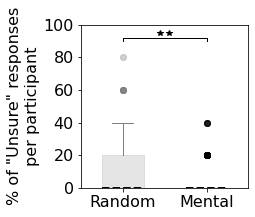

In [174]:
summary_fullDat = 100*fullDat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary_fullDat.shape
fig = plt.figure(1,figsize = (3,3))
ax = fig.add_subplot(111)
summary_fullDat = plot_fig_1e(ax,summary_fullDat)

In [185]:
summary1 = summary.rename(columns={'Random': 'pc_unc_Rand', 'Mental': 'pc_unc_Mental'})
summary1.mean(),summary1.sem()

(stim
 pc_unc_Rand      9.404617
 pc_unc_Mental    2.697448
 dtype: float64,
 stim
 pc_unc_Rand      0.502480
 pc_unc_Mental    0.259658
 dtype: float64)

In [186]:
summary1_fullDat = summary_fullDat.rename(columns={'Random': 'pc_unc_Rand', 'Mental': 'pc_unc_Mental'})
summary1_fullDat.mean(),summary1_fullDat.sem()

(stim
 pc_unc_Rand      9.443099
 pc_unc_Mental    2.687651
 dtype: float64,
 stim
 pc_unc_Rand      0.504647
 pc_unc_Mental    0.258776
 dtype: float64)

Formula: uncertainty~stim+(1|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0}

Log-likelihood: -1786.132 	 AIC: 3578.264

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.412  0.642

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.430  -2.576   -2.283  0.075  0.088      0.076       0.102   
stim1          -1.345  -1.563   -1.127  0.111  0.261      0.210       0.324   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.081        0.071         0.093 -32.561    0.0  ***  
stim1        0.207        0.173         0.245 -12.107    0.0  ***  


(array([3738., 3994.,    0.,    0.,    0.,    0.,    0.,   66.,  321.,
         111.]),
 array([-0.68206587, -0.34415181, -0.00623775,  0.33167631,  0.66959038,
         1.00750444,  1.3454185 ,  1.68333257,  2.02124663,  2.35916069,
         2.69707476]),
 <BarContainer object of 10 artists>)

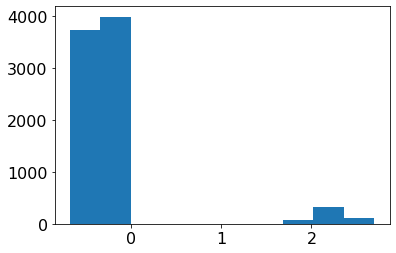

In [177]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim + (1|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0}

Log-likelihood: -1794.225 	 AIC: 3594.450

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.426  0.653

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.430  -2.577   -2.284  0.075  0.088      0.076       0.102   
stim1          -1.354  -1.572   -1.137  0.111  0.258      0.208       0.321   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.081        0.071         0.092 -32.587    0.0  ***  
stim1        0.205        0.172         0.243 -12.197    0.0  ***  


(array([3750., 4009.,    0.,    0.,    0.,    0.,    0.,   69.,  321.,
         111.]),
 array([-0.68973961, -0.35087539, -0.01201118,  0.32685304,  0.66571726,
         1.00458147,  1.34344569,  1.68230991,  2.02117412,  2.36003834,
         2.69890256]),
 <BarContainer object of 10 artists>)

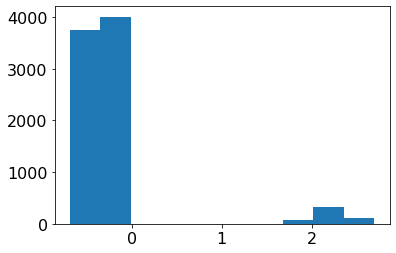

In [178]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim + (1|subj_idx)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -1657.524 	 AIC: 3323.049

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.404  0.635
movie     (Intercept)  0.769  0.877

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.642  -3.426   -1.858  0.400  0.071      0.033       0.156   
stim1          -1.607  -2.732   -0.482  0.574  0.200      0.065       0.617   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.066        0.032         0.135  -6.607  0.000  ***  
stim1        0.167        0.061         0.382  -2.800  0.005   **  


(array([ 709., 6308.,  715.,    0.,    0.,   15.,  234.,  181.,   59.,
           9.]),
 array([-0.94263935, -0.52749636, -0.11235337,  0.30278962,  0.71793261,
         1.1330756 ,  1.54821859,  1.96336158,  2.37850457,  2.79364756,
         3.20879055]),
 <BarContainer object of 10 artists>)

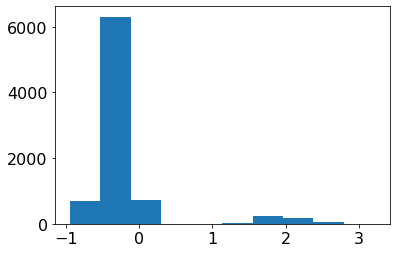

In [53]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(1|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(1|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -1666.108 	 AIC: 3340.216

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.417  0.646
movie     (Intercept)  0.764  0.874

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.639  -3.421   -1.858  0.399  0.071      0.033       0.156   
stim1          -1.619  -2.742   -0.497  0.573  0.198      0.064       0.608   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.067        0.032         0.135  -6.619  0.000  ***  
stim1        0.165        0.061         0.378  -2.828  0.005   **  


(array([ 713., 5865., 1181.,    0.,    0.,   16.,  234.,  183.,   59.,
           9.]),
 array([-0.94999613, -0.53405553, -0.11811492,  0.29782569,  0.7137663 ,
         1.1297069 ,  1.54564751,  1.96158812,  2.37752873,  2.79346934,
         3.20940994]),
 <BarContainer object of 10 artists>)

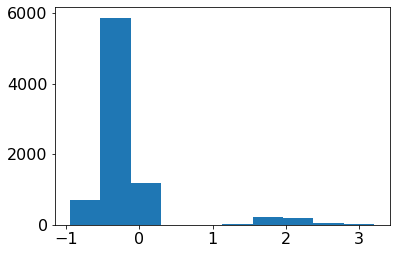

In [179]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(1|subj_idx) + (1|movie)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0}

Log-likelihood: -1771.144 	 AIC: 3552.288

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.762  0.873
subj_idx   stimMental  4.264  2.065

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.561

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.562  -2.742   -2.382  0.092  0.077      0.064       0.092   
stim1          -2.144  -2.792   -1.496  0.331  0.117      0.061       0.224   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.072        0.061         0.085 -27.963    0.0  ***  
stim1        0.105        0.058         0.183  -6.482    0.0  ***  


(array([ 242., 3885., 3605.,    0.,    0.,    0.,    0.,   44.,  144.,
         310.]),
 array([-0.88346837, -0.55418876, -0.22490916,  0.10437045,  0.43365006,
         0.76292967,  1.09220927,  1.42148888,  1.75076849,  2.0800481 ,
         2.4093277 ]),
 <BarContainer object of 10 artists>)

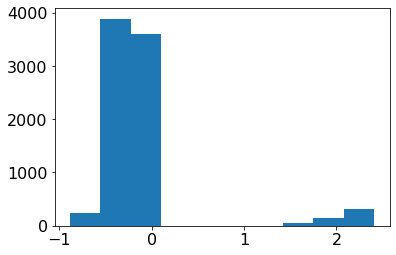

In [180]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0}

Log-likelihood: -1778.655 	 AIC: 3567.309

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.789  0.888
subj_idx   stimMental  4.345  2.085

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.566

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.567  -2.747   -2.387  0.092  0.077      0.064       0.092   
stim1          -2.152  -2.803   -1.502  0.332  0.116      0.061       0.223   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.071        0.060         0.084 -27.975    0.0  ***  
stim1        0.104        0.057         0.182  -6.484    0.0  ***  


(array([ 220., 3919., 3620.,    0.,    0.,    0.,    0.,   47.,  144.,
         310.]),
 array([-0.89494758, -0.564549  , -0.23415042,  0.09624817,  0.42664675,
         0.75704533,  1.08744391,  1.41784249,  1.74824107,  2.07863966,
         2.40903824]),
 <BarContainer object of 10 artists>)

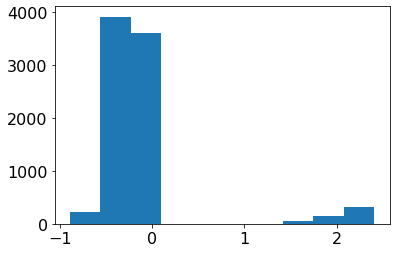

In [181]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8230	 Groups: {'subj_idx': 823.0, 'movie': 10.0}

Log-likelihood: -1651.062 	 AIC: 3314.124

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.709  0.842
subj_idx   stimMental  1.457  1.207
movie     (Intercept)  0.752  0.867

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.776

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.762  -3.541   -1.983  0.397  0.063      0.029       0.138   
stim1          -1.570  -2.720   -0.420  0.587  0.208      0.066       0.657   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.059        0.028         0.121  -6.950  0.000  ***  
stim1        0.172        0.062         0.396  -2.677  0.007   **  


(array([ 121., 2785., 4826.,    0.,    0.,   46.,  187.,  175.,   81.,
           9.]),
 array([-1.14070547, -0.71345854, -0.2862116 ,  0.14103533,  0.56828227,
         0.9955292 ,  1.42277613,  1.85002307,  2.27727   ,  2.70451693,
         3.13176387]),
 <BarContainer object of 10 artists>)

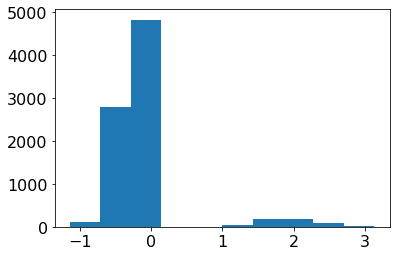

In [182]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8260	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -1659.201 	 AIC: 3330.401

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.735  0.857
subj_idx   stimMental  1.496  1.223
movie     (Intercept)  0.748  0.865

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.781

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.764  -3.540   -1.988  0.396  0.063      0.029       0.137   
stim1          -1.573  -2.718   -0.427  0.584  0.208      0.066       0.652   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.059        0.028         0.120  -6.983  0.000  ***  
stim1        0.172        0.062         0.395  -2.691  0.007   **  


(array([ 122., 2793., 4844.,    0.,    0.,   47.,  187.,  177.,   81.,
           9.]),
 array([-1.15296277, -0.72436084, -0.2957589 ,  0.13284303,  0.56144497,
         0.99004691,  1.41864884,  1.84725078,  2.27585271,  2.70445465,
         3.13305659]),
 <BarContainer object of 10 artists>)

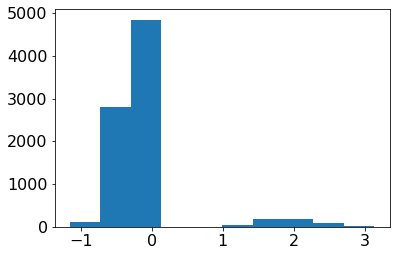

In [183]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx) + (1|movie)', data=fullDat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

In [187]:
# save data for trait analysis etc.
summary1.to_csv(os.path.join(file_loc,'data_for_paper','1e_S_NS_pc_uncertainResp_per_subj.csv'))
summary1_fullDat.to_csv(os.path.join(file_loc,'data_for_paper','1e_S_NS_pc_uncertainResp_per_subj_fullDat.csv'))

## Plot all subplots together

In [188]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

NameError: name 'matplotlib' is not defined

In [189]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [190]:
fig_save_loc = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig1_hcpbeh'

mean diff: 5.7843931416227905
Ttest_relResult(statistic=-9.955057612909297, pvalue=4.0348763675618627e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
26813.5 , 1.0623685894361655e-18 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
before: (823, 2)
after: (823, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


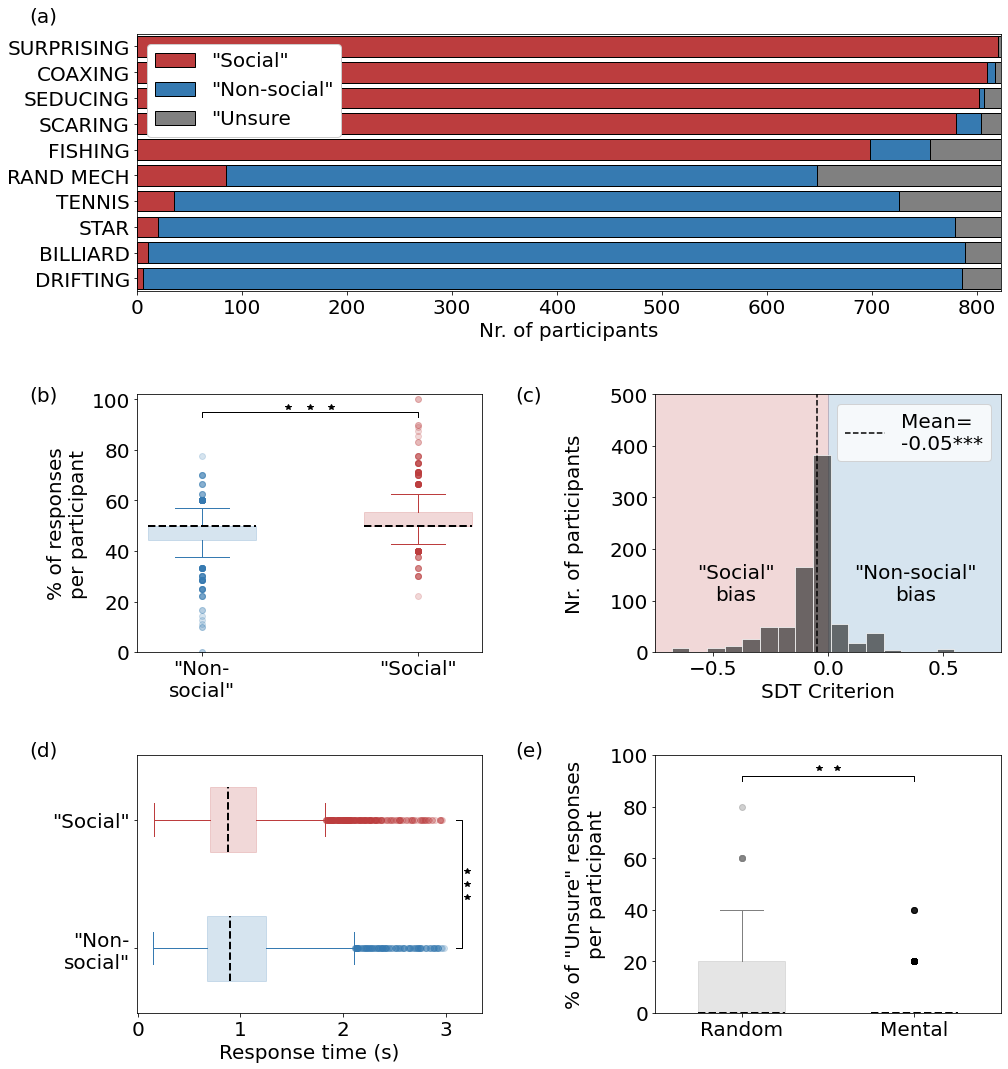

In [192]:
fig = plt.figure(1,figsize = (15,17))
ax = fig.add_subplot(311)
#plot_fig_1a(ax)
plot_fig_1a(ax,counts)
#plot_fig_1a(ax,counts_fullDat)

ax = fig.add_subplot(323)
#plot_fig_1b(ax)
plot_fig_1b(ax,counts_per_subj)
#plot_fig_1b(ax,counts_per_subj_fullDat)
ax.set_xlim(-0.3,1.3)
#ax.set_ylabel(fontsize = 20)

ax = fig.add_subplot(324)
#plot_fig_1c(ax)
plot_fig_1c(ax,sdt_measures)
#plot_fig_1c(ax,sdt_measures_fullDat)

ax = fig.add_subplot(325)
#plot_fig_1d(ax)
plot_fig_1d(ax, p_rt)
#plot_fig_1d(ax, p_rt_fullDat)

ax = fig.add_subplot(326)
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
summary = plot_fig_1e(ax,summary)

'''summary_fullDat = 100*fullDat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary_fullDat.shape
fig = plt.figure(1,figsize = (3,3))
summary_fullDat = plot_fig_1e(ax,summary_fullDat)'''

#summary = plot_fig_1e(ax,summary)

fig.text(0,.91,'(a)',fontsize=20)
fig.text(0,.6,'(b)',fontsize=20)
fig.text(0,.31,'(d)',fontsize=20)
fig.text(0.45,.6,'(c)',fontsize=20)
fig.text(0.45,.31,'(e)',fontsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
#plt.tight_layout()


plt.savefig(os.path.join(fig_save_loc,'Figure1.png'),dpi=300,bbox_inches='tight',facecolor='w')

mean diff: 5.839482685729659
Ttest_relResult(statistic=-10.0512171700471, pvalue=1.680706301406872e-22)
when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
26834.0 , 4.435764321171681e-19 when writing as p<10^(-...), reduce the expo value by 1 (i.e., 1.06e-18 is p< 10^-17!!
before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


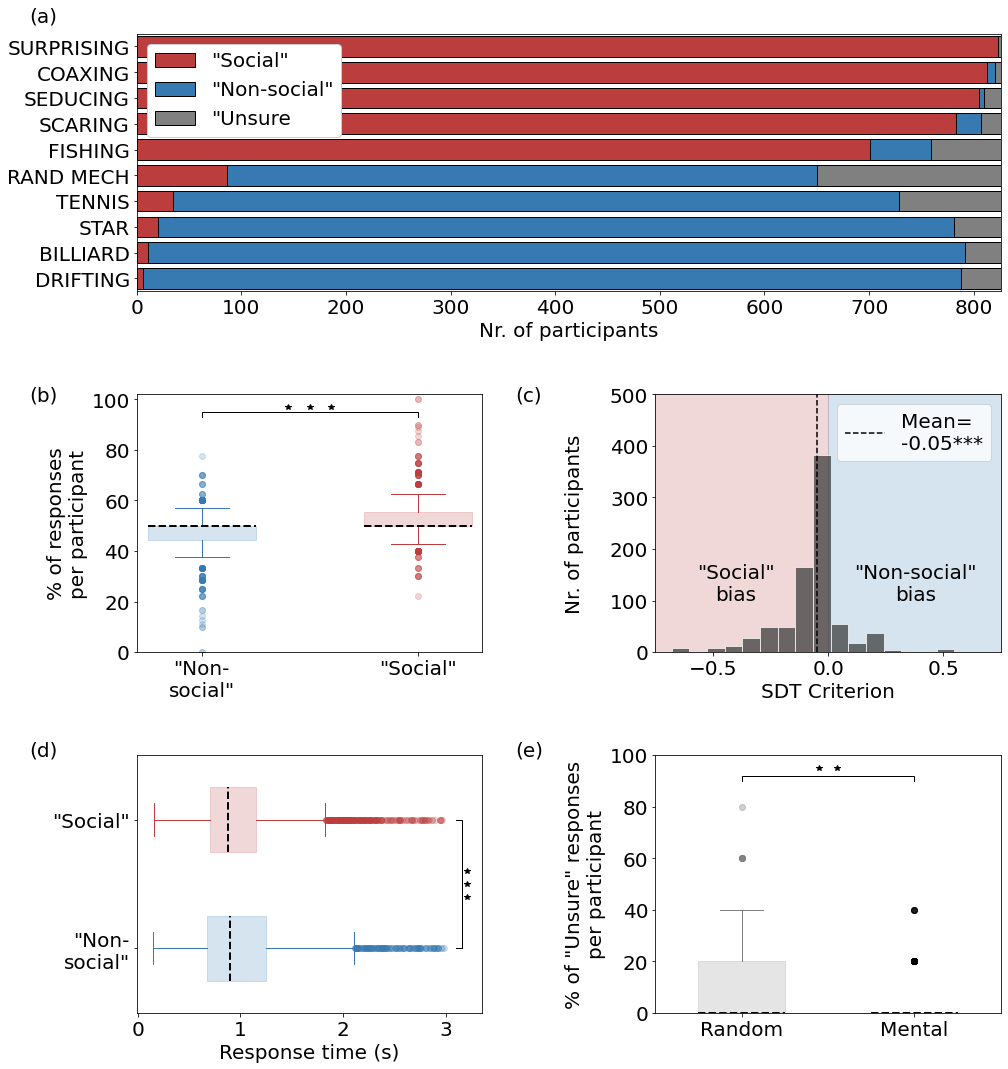

In [195]:
# full data

fig = plt.figure(1,figsize = (15,17))
ax = fig.add_subplot(311)
#plot_fig_1a(ax)
#plot_fig_1a(ax,counts)
plot_fig_1a(ax,counts_fullDat)

ax = fig.add_subplot(323)
#plot_fig_1b(ax)
#plot_fig_1b(ax,counts_per_subj)
plot_fig_1b(ax,counts_per_subj_fullDat)
ax.set_xlim(-0.3,1.3)
#ax.set_ylabel(fontsize = 20)

ax = fig.add_subplot(324)
#plot_fig_1c(ax)
#plot_fig_1c(ax,sdt_measures)
plot_fig_1c(ax,sdt_measures_fullDat)

ax = fig.add_subplot(325)
#plot_fig_1d(ax)
#plot_fig_1d(ax, p_rt)
plot_fig_1d(ax, p_rt_fullDat)

ax = fig.add_subplot(326)
'''summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
summary = plot_fig_1e(ax,summary)'''

summary_fullDat = 100*fullDat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary_fullDat.shape
fig = plt.figure(1,figsize = (3,3))
summary_fullDat = plot_fig_1e(ax,summary_fullDat)

#summary = plot_fig_1e(ax,summary)

fig.text(0,.91,'(a)',fontsize=20)
fig.text(0,.6,'(b)',fontsize=20)
fig.text(0,.31,'(d)',fontsize=20)
fig.text(0.45,.6,'(c)',fontsize=20)
fig.text(0.45,.31,'(e)',fontsize=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.4)
#plt.tight_layout()


plt.savefig(os.path.join(fig_save_loc,'Figure1_fullDat.png'),dpi=300,bbox_inches='tight',facecolor='w')

In [71]:
sns.barplot(data=summary.loc[:,['pc_unc_Rand','pc_unc_Mental']].melt(),x='stim',y='value')
     
#Figure 1c in the submitted OHBM abstract
#sns.barplot(data=summary,alpha=.5,edgecolor='k')
plt.xticks((0,1),('Random','Mental'))
plt.xlabel('')
plt.ylabel("Unsure responses\n(in percent)")
#plt.title('Unsure responses',fontweight='bold')


KeyError: "None of [Index(['pc_unc_Rand', 'pc_unc_Mental'], dtype='object', name='stim')] are in the [columns]"

# extra analyses

## response counts

In [ ]:
# - So looks like there are movie-specific differences in uncertainty and accuracy - are these correlated?
stats.pearsonr(count_unsure_per_movie.values,acc_per_movie.values)

#- Indeed, looks like there's a negative correlation - i.e., movies with higher uncertainty have lower accuracies - which makes sense
 
#mean responses per subject - if this is above 0.5, it shows a bias for '1' or 'yes' responses

plt.figure(1,figsize =(6,3))
plt.subplot(121)
mean_r = data_sure.groupby(["subj_idx"]).mean().response # pandas series of mean responses per subj
plt.hist(mean_r, bins = 10, alpha = 0.5)
plt.xlabel("Fraction of 'yes' responses")
plt.ylabel("Number of subjects")
ymin,ymax = plt.ylim()
plt.vlines(.5,ymin,ymax, 'k', linestyle = 'dashed', label = '0.5')
plt.vlines(np.mean(mean_r),ymin,ymax, 'r', linestyle = 'dashed', label = 'mean')
plt.ylim(0,450)
plt.tight_layout()
plt.legend()

# another way to test for a social bias: look at the #yes/#no ratio --> if >1 this suggests 
# a yes bias

yes_to_no = counts_per_subj[1]/counts_per_subj[0]

plt.subplot(122)
yes_to_no.hist(bins = 30,alpha = 0.4)
plt.grid(None)
#print(np.unique(yes_to_no))
plt.xlabel("YES/NO ratio")
plt.xticks(range(10))
plt.ylabel("# subs")
plt.plot(np.ones((11,1))*np.mean(yes_to_no), np.arange(0,550,50), 'r', ls = 'dashed',label = 'mean')
#plt.ylim(0,450)
plt.tight_layout()
plt.legend(bbox_to_anchor =[1.01,1])
#print(np.mean(yes_to_no))
stats.wilcoxon(yes_to_no-1)

## accuracy

In [ ]:
### (b) Accuracies social v. nonsocial (OHBM 2021 ABSTRACT FIG 1A)
# compare social and random trial accuracies, exploring df 

accuracy_per_subj = data_sure.groupby(['subj_idx', 'stim']).mean().accuracy # Mean acc. per subject for Mental and Random
cols = accuracy_per_subj.unstack(level = -1)
print(cols,'\n') # subj_idx and stim are indices, so unstack makes stim columns (with the default level value)
print('MEAN ',cols.mean(),'\n') # mean acc across subjects
print('SEM ',cols.sem(),'\n') # sem acc across subjects
#print('COLUMNS', cols.columns) # Mental and random become columns with unstack

plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.bar(range(2),cols.mean(),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(range(2),cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.xticks((range(2)),('Social','Non-social'), fontsize = 14)
plt.title('Accuracy', fontsize =14, fontweight = 'bold')
plt.ylim(0.9,0.97)

stats.ttest_rel(cols['Mental'],cols['Random'],nan_policy='omit')


responses_per_subj = data_sure.groupby(['subj_idx']).mean().response # Mean acc. per subject for Mental and Random

plt.subplot(122)
plt.bar(1,np.nanmean(responses_per_subj.values),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(1,np.nanmean(responses_per_subj.values),stats.sem(responses_per_subj,nan_policy='omit'), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.yticks([0.4,0.5,0.6],['0.4','fr.Yes=\nfr.No','0.6'], fontsize = 14)
plt.title('Responses', fontsize =14, fontweight = 'bold')
plt.ylim(0.4,0.6)
plt.xlim(0,2)
plt.xticks([])

plt.tight_layout()
stats.ttest_1samp(responses_per_subj.values,.5,nan_policy='omit')

- Hence, the yes to no ratio is greater than 1 and significant --> i.e., more yes's than no's overall

## Supplementary analyses: Movie-wise trends - Accuracy per movie  and #unsure responses/movie


([<matplotlib.axis.XTick at 0x7ff60187e390>,
 [Text(0, 0, 'COAX'),
  Text(1, 0, 'FISH'),
  Text(2, 0, 'SEDU'),
  Text(3, 0, 'SURP'),
  Text(4, 0, 'SCAR'),
  Text(5, 0, 'BILL'),
  Text(6, 0, 'DRIF'),
  Text(7, 0, 'RAND'),
  Text(8, 0, 'STAR'),
  Text(9, 0, 'TENN')])

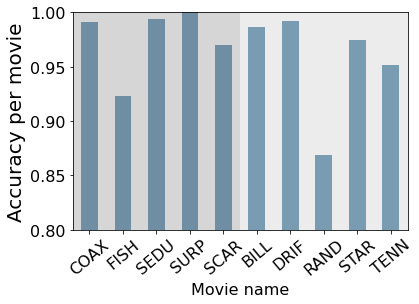

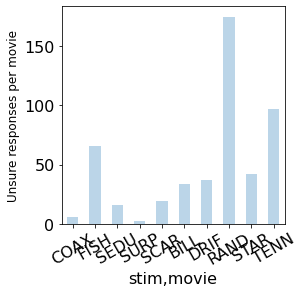

In [62]:
#Accuracy per movie (OHBM ABSTRACT FIG 2A)
acc_per_movie = data_sure.groupby(['stim','movie']).mean().accuracy
#print('acc_per_movie')
#print(acc_per_movie)

# (for the figure axlabels) creating groupwise movie name labels from the variable acc_per_movie
movieNames_grouped = []
for i in range(len(acc_per_movie.index)):
    movieNames_grouped.append(acc_per_movie.index[i][1])
#print('movieNames_grouped:',movieNames_grouped)
lbl = [str.upper(i[0:5]) for i in movieNames_grouped] # first four letters of each movie name

acc_per_movie.plot.bar(color = [0,0.3,0.5], alpha = 0.5)
plt.xlabel("Movie name")
plt.ylabel('Accuracy per movie', fontsize = 20)
lbl = [str.upper(i[0:4]) for i in movieNames_grouped] # first four letters of each movie name
plt.xticks(range(10),lbl, rotation = 40)
plt.axvspan(-0.5,4.5, facecolor='0.2', alpha=0.2) # background color for the first 5 bars(mental?)
plt.axvspan(4.5,10, facecolor='0.3', alpha=0.1) # bgcolor for the next 5 bars (random?)
plt.xlim(-0.5,9.5)
plt.ylim(0.8,1)

plt.figure(2)
#Unsure trials per movie
count_unsure_per_movie = data_unsure.groupby(['stim','movie']).size()
#print('count_unsure_per_movie')
#print(count_unsure_per_movie)

# Plot no. of uncertain responses per movie
count_unsure_per_movie.plot.bar(figsize = (4,4), x ='', y ='', linestyle = 'None', alpha = 0.3)
plt.ylabel('Unsure responses per movie', fontsize = 12)
plt.xticks(range(10),lbl, rotation = 30)



## SDT - extra analyses

In [ ]:
# Distribution of #responses all 4 response types, esp. errors
print(data_sure.groupby(['stim','response']).count())
data_sure.groupby(['stim','response']).count().transpose().loc['accuracy',:].plot.bar()
plt.xticks(range(4),('Miss','Hit','CR','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")

fig,ax = plt.subplots(figsize = (5,4))
data_sure.groupby(['stim','response']).count().transpose().iloc[1,[0,3]].plot.bar()
plt.xticks(range(2),('Miss','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")



## LME - extra analysis

In [ ]:
## Response modelling
# model to look for a general bias in responses. The analysis below is a logistic regression,
# so our hypothesis is  if logOR of intercept > 0?
model = Lmer('response ~ (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit()) 

### response

In [ ]:
# Next model: response = f(stimulus Type)
model = Lmer('response ~ stim + (1|subj_idx)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())


#Does adding movie improve the model?
model = Lmer('response ~ stim + (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
 
# adding random slopes for subject
model = Lmer('response ~ stim + (stim|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())

### RT

In [ ]:
# since RT is quantitative, these analyses are linear regressions
model = Lmer('logRT ~  stim +(stim|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term

# plotting the results
fig,ax = plt.subplots(figsize = (5,5))
sns.violinplot(data=data_sure, x="stim",y="logRT", ax=ax)
ax.axhline(0, linestyle='--')
print(data_sure.groupby("stim").mean().rt)

In [ ]:
# Distribution of all 4 response types, esp. errors

rt_per_respType = data_sure.groupby(['stim','accuracy']).mean().rt
print(rt_per_respType.index)
print(rt_per_respType)
fig,ax = plt.subplots(figsize = (10,4))
#acc_per_movie.plot.bar()
rt_per_respType.plot.bar(figsize = (4,4), alpha = 0.3)
ax.set_ylabel('Mean RT', fontsize = 12)
ax.set_xticks(range(4))
lbl = ['FN','Hit','FP','CR'] # first four letters of each movie name
ax.set_xticklabels(lbl, rotation = 30)

ax.set_xlabel('')

## looks like there's a strong interaction between stim and resp
 
# does the influence of stim and response depend on each other?
model = Lmer('logRT ~  stim*response + (1|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]}))

# logRT =f(accuracy)
model = Lmer('logRT ~  accuracy +(accuracy|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

## uncertainty - extra analyses

In [68]:
n = len(vid_names["run1"])+len(vid_names["run2"])
socialness = np.zeros(len(dat['response']))
for m in range(n):
    rows = np.where(dat["movie"] == stim_mean.index[m])[0]
    socialness[rows] = stim_mean[m]
dat['socialness'] = socialness # add new column
dat.head()

,subj_idx,stim,movie,rt,response,run,accuracy,certainty,uncertainty,socialness
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,1,0,0.964824
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,1,0,0.981057
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,1,0,0.043433
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,1,0,0.983317
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,1,0,0.055879


Formula: certainty~socialness+(socialness|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.136 	 AIC: 4250.272

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.976  0.988
subj_idx   socialness  0.766  0.875
movie     (Intercept)  0.577  0.760

                  IV1         IV2  Corr
subj_idx  (Intercept)  socialness -0.54

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     2.646   1.922    3.370  0.370  14.098      6.832      29.092   
socialness      1.467   0.380    2.554  0.554   4.336      1.462      12.854   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.934        0.872         0.967   7.159  0.000  ***  
socialness   0.813        0.594         0.928   2.645  0.008   **  


(array([4.000e+01, 1.620e+02, 3.270e+02, 9.500e+01, 1.600e+01, 1.000e+00,
        0.000e+00, 8.035e+03, 1.233e+03, 3.900e+01]),
 array([-2.93294977, -2.50620858, -2.0794674 , -1.65272621, -1.22598502,
        -0.79924384, -0.37250265,  0.05423853,  0.48097972,  0.9077209 ,
         1.33446209]),
 <BarContainer object of 10 artists>)

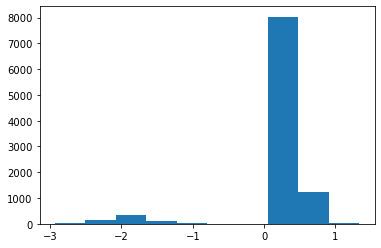

In [141]:
# certainty of responses as a function of perceived socialness
model = Lmer('certainty ~  socialness +(socialness|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: certainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.181 	 AIC: 4250.363

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.833  0.912
subj_idx   stimRandom  0.626  0.791
movie     (Intercept)  0.560  0.748

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimRandom -0.382

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     4.083   3.371    4.796  0.364  59.336     29.096     121.003   
stimRandom     -1.373  -2.350   -0.396  0.499   0.253      0.095       0.673   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.983        0.967         0.992  11.231  0.000  ***  
stimRandom   0.202        0.087         0.402  -2.753  0.006   **  


(array([3.800e+01, 1.340e+02, 2.430e+02, 2.100e+02, 1.500e+01, 1.000e+00,
        0.000e+00, 8.030e+03, 1.238e+03, 3.900e+01]),
 array([-2.93187413, -2.50715138, -2.08242863, -1.65770587, -1.23298312,
        -0.80826037, -0.38353761,  0.04118514,  0.46590789,  0.89063065,
         1.3153534 ]),
 <BarContainer object of 10 artists>)

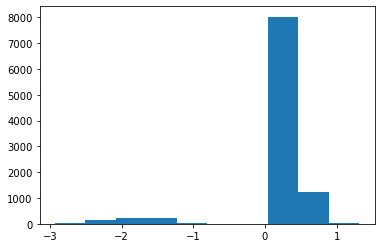

In [144]:
# certainty as a function of stimtype
model = Lmer('certainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

In both the analyses above, the regressors where significant indicating that response certainty can be predicted from binary stimType or continuous (based on general consensus) socialness

In [291]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0}

Log-likelihood: -2249.163 	 AIC: 4508.326

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.889  0.943
subj_idx   stimMental  2.737  1.654

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.349

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.571  -2.740   -2.402  0.086  0.076      0.065       0.091   
stim1          -1.796  -2.292   -1.300  0.253  0.166      0.101       0.273   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.071        0.061         0.083 -29.745    0.0  ***  
stim1        0.142        0.092         0.214  -7.093    0.0  ***  


stim
Mental    0.966444
Random    0.902034
Name: certainty, dtype: float64


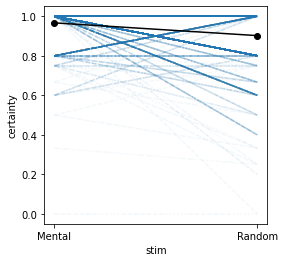

In [148]:
# Alternate version of the last plot showing individual values
fig,ax = plt.subplots(figsize = (4,4))
summary = dat.groupby(['subj_idx','stim']).mean()
print(summary.reset_index().groupby('stim').mean().certainty)
sns.lineplot(data=summary, x="stim", y="certainty", style="subj_idx",legend = False, alpha = 0.05)
plt.plot(summary.reset_index().groupby('stim').mean().certainty, color = 'black', marker = 'o')
#summary.plot(x="stim",y="response", stacked = True)
#ax.set_xticks((0,1))
#ax.set_xticklabels(('No','Yes'), fontsize = 'x-large')
#ax.set_ylabel("RT", fontsize = 'x-large')

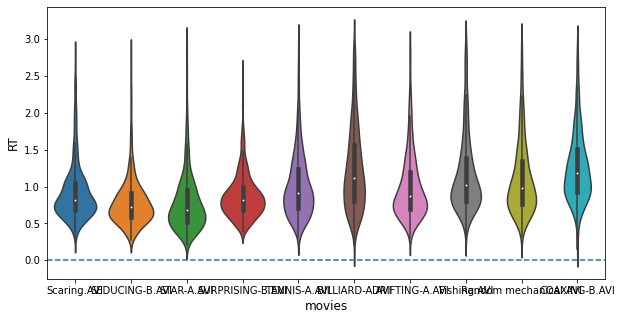

In [161]:
#RT across mean socialness values (or movies)
fig,ax = plt.subplots(figsize = (10,5))
sns.violinplot(x="movie",y="rt",data=data_sure, ax=ax)
ax.set_xticks(range(10))
ax.set_xlabel('movies',fontsize = 12)
ax.set_ylabel('RT',fontsize = 12)
ax.axhline(0, linestyle='--')

# Extra code

<AxesSubplot:xlabel='diff'>

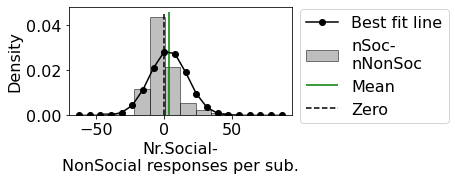

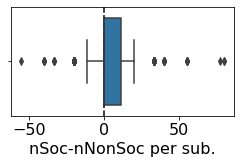

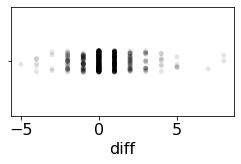

In [249]:
fig = plt.figure(1, figsize=(4,2))

data = counts_per_subj['Soc-NonSoc_pc'].values
_, bins, _ = plt.hist(data, 12, density=1, alpha=0.5,color = 'grey',label = 'nSoc-\nnNonSoc', align = 'mid',edgecolor = 'k')
#plt.hist(data,bins=bins)

mu, sigma = scipy.stats.norm.fit(data)
xmin,xmax = plt.xlim()
x =  np.linspace(xmin,xmax,20)
best_fit_line = scipy.stats.norm.pdf(x, mu, sigma)
plt.plot(x, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('Nr.Social-\nNonSocial responses per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [1,1.05])

plt.figure(2, figsize=(4,2))

sns.boxplot(x=data)
#sns.boxplot(x="diff", data = cols)
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('nSoc-nNonSoc per sub.')

plt.figure(3, figsize=(4,2))
sns.stripplot(x = "diff", data = counts_per_subj, color = 'k',  alpha = .1)

